In [45]:
#loading packages
library(plyr); library(dplyr)
library(ggplot2)
#library(HTSSIP)
library(phyloseq)
library(data.table)
library(stringr)
library(tidyr)
library(RColorBrewer)
library(cowplot)

In [22]:
#importing metadata
sample.md = read.table("data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

In [23]:
#renaming Density column to Buoyant Density"
setnames(sample.md, "Density", "Buoyant_density")

In [24]:
#importing biom data
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom") 

In [25]:
#adding sample data to physeq object
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

In [188]:
physeq %>% sample_data %>% head

,SampleID,Primers,i2,i1,Day,Buoyant_density,Treatment,Mock_Comm,RNA_DNA
succ.12C.D14,succ.12C.D14,81,gtctatga,atcgtacg,14,NA,12CCPS,bulk,DNA
succ.13C.D30,succ.13C.D30,86,gtctatga,cgtgagtg,30,NA,13CCPS,bulk,DNA
succ.12C.D7,succ.12C.D7,80,gtctgcta,gacaccgt,7,NA,12CCPS,bulk,DNA
succ.13C.D3,succ.13C.D3,83,gtctatga,tagcgagt,3,NA,13CCPS,bulk,DNA
succ.13C.D14,succ.13C.D14,85,gtctatga,tcatcgag,14,NA,13CCPS,bulk,DNA
succ.12C.D30,succ.12C.D30,82,gtctatga,actatctg,30,NA,12CCPS,bulk,DNA


In [189]:
#pruning physeq object to heavy fractions only
dna.density.min = 1.7125

md = sample_data(physeq)
criterion = md$Buoyant_density >= with(md, dna.density.min)

physeq.heavy = prune_samples(criterion, physeq)

In [190]:
physeq.heavy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 76 samples ]
sample_data() Sample Data:       [ 76 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

In [191]:
#Checking for correct format in physeq object
physeq.heavy = physeq_format(physeq.heavy)

In [192]:
physeq.heavy %>% sample_data %>% .[1:4,1:9]


,SampleID,Primers,i2,i1,Day,Buoyant_density,Treatment,Mock_Comm,RNA_DNA
D713.15,D713.15,135,ggatatct,gatctacg,7,1.720939,13CCPS,N,DNA
D3012.7,D3012.7,67,tagcgagt,actacgac,30,1.752629,12CCPS,N,DNA
D1412.3,D1412.3,1,atcgtacg,cgagagtt,14,1.755907,12CCPS,N,DNA
D1413.10,D1413.10,31,ggatatct,actcactg,14,1.729681,13CCPS,N,DNA


In [193]:
#creating expression to subset physeq objects 
ex = "(Treatment=='12CCPS' & Day=='${Day}') | (Treatment=='${Treatment}' & Day == '${Day}')"

In [194]:
#creating set of parameters for use in subsetting physeq object
params = get_treatment_params(physeq.heavy, c('Treatment', 'Day'), "Treatment != '12CCPS'")
params

Treatment,Day
13CCPS,7
13CCPS,14
13CCPS,30
13CCPS,3


In [195]:
#subsetting physeq object based on above parameters inserted into above expression 
physeq.heavy.filt = phyloseq_subset(physeq.heavy, params, ex)
physeq.heavy.filt

$`(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='14') | (Treatment=='13CCPS' & Day == '14')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 20 samples ]
sample_data() Sample Data:       [ 20 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='30') | (Treatment=='13CCPS' & Day == '30')`
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 18 samples ]
sample_data() Sample Data:       [ 18 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]

$`(Treatment=='12CCPS' & Day=='3') | (Treatment=='13CCPS'

In [196]:
# adjusted P-value cutoff 
padj_cutoff = 0.1
# number of cores for parallel processing (increase depending on your computational hardware)
ncores = 5

In [197]:
windows = data.frame(density_min=c(1.70, 1.72, 1.74), 
                     density_max=c(1.73, 1.75, 1.77))
windows

density_min,density_max
1.70,1.73
1.72,1.75
1.74,1.77


In [198]:
thresh = seq(0.05, 0.95, 0.05)

thresh

[1] 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75
[16] 0.80 0.85 0.90 0.95

In [199]:
##Running with multiple windows
doParallel::registerDoParallel(ncores)

df_l2fc = plyr::ldply(physeq.heavy.filt, 
                      HRSIP, 
                      density_windows = windows,
                      design = ~Treatment, 
                      padj_cutoff = padj_cutoff,
                      sparsity_threshold = thresh, # just using 3 thresholds to reduce run time
                      .parallel = TRUE)
df_l2fc %>% head(n=3)

.id,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.240,-0.6881657,0.9308557,1,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.85,-0.6977640,0.9645360,1,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.26,-0.3061061,0.9902476,1,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25


In [200]:
df_l2fc %>% .$.id %>% unique


[1] "(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7')"  
[2] "(Treatment=='12CCPS' & Day=='14') | (Treatment=='13CCPS' & Day == '14')"
[3] "(Treatment=='12CCPS' & Day=='30') | (Treatment=='13CCPS' & Day == '30')"
[4] "(Treatment=='12CCPS' & Day=='3') | (Treatment=='13CCPS' & Day == '3')"

In [201]:
head(df_l2fc)

.id,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.240,-0.6881657,0.9308557,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.85,-0.6977640,0.9645360,1.0000000,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.26,-0.3061061,0.9902476,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.15,-0.5955299,0.9987957,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.30405,1.4759677,0.1687382,0.7466573,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7,1.73,0.3,all,0.25
(Treatment=='12CCPS' & Day=='7') | (Treatment=='13CCPS' & Day == '7'),OTU.190,-0.4806614,0.9238682,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,NA,NA,NA,NA,1.7,1.73,0.3,all,0.25


In [202]:
#substr(df_l2fc$.id, start, stop)
#> strsplit("BLAAT1\022E:\\BLAAT2\\BLAAT3","\\",fixed=TRUE)

#head(strsplit(df_l2fc$.id, " ", fixed = TRUE))# %>% strsplit(df_l2fc$.id, "", fixed = TRUE)

df_l2fc2 = df_l2fc %>%
  separate(.id, c("1","2", "3", "4", "daytest"),"==") %>% separate(daytest, c("6", "Day"), "'") %>% select(-c(1:5))

Warning message:
“Too many values at 1521 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...”

In [203]:
write.table(df_l2fc2, "data/l2fc_UNITE_MW.csv", row.names = FALSE, sep = ",")

In [5]:
df_l2fc2 = read.table("data/l2fc_UNITE_MW.csv", sep = ",", header = TRUE)
head(df_l2fc2)

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
7,OTU.240,-0.6881657,0.9308557,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25
7,OTU.85,-0.6977640,0.9645360,1.0000000,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25
7,OTU.26,-0.3061061,0.9902476,1.0000000,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25
7,OTU.15,-0.5955299,0.9987957,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7,1.73,0.3,all,0.25
7,OTU.30405,1.4759677,0.1687382,0.7466573,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7,1.73,0.3,all,0.25
7,OTU.190,-0.4806614,0.9238682,1.0000000,k__Fungi,p__Ascomycota,c__Dothideomycetes,NA,NA,NA,NA,1.7,1.73,0.3,all,0.25


In [6]:
df_l2fc2 %>% summarise(meanl2fc = mean(log2FoldChange), sdl2fc = sd(log2FoldChange))

meanl2fc,sdl2fc
1.116494,2.259502


In [7]:
padj_cutoff = 0.1

df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  group_by(Day, sparsity_threshold) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  as.data.frame

Day,sparsity_threshold,n_incorp_OTUs
3,0.45,74
7,0.30,82
14,0.20,96
30,0.40,70


In [8]:
#Number of unique responders
df.sig = df_l2fc2 %>% 
  filter(padj < padj_cutoff)

length(unique(df.sig$OTU))

[1] 193

In [9]:
#days of response per OTU
padj_cutoff = 0.1

df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  group_by(OTU) %>%
  mutate(respDays = Day %>% unique %>% length) %>%
  group_by(respDays) %>%
  summarise(nOTUs = OTU %>% unique %>% length) %>%
  as.data.frame

respDays,nOTUs
1,118
2,33
3,30
4,12


In [10]:
df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  group_by(OTU) %>%
  mutate(respDays = Day %>% unique %>% length) %>%
  filter(respDays == 1) %>% 
  group_by(Day) %>% 
  summarise(nOTU = OTU %>% unique %>% length)

Day,nOTU
3,47
7,21
14,38
30,12


In [11]:
#Classes of responders
df.sig %>% 
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Rank2, Rank3, Rank6, Rank7) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) 

Rank2,Rank3,Rank6,Rank7,n_incorp_OTUs
Ascomycota,Dothideomycetes,Dendryphion,Dendryphion nanum,1
Ascomycota,Dothideomycetes,Preussia,NA,1
Ascomycota,Dothideomycetes,NA,NA,3
Ascomycota,Eurotiomycetes,Aspergillus,Aspergillus penicillioides,1
Ascomycota,Eurotiomycetes,Aspergillus,NA,2
Ascomycota,Eurotiomycetes,Exophiala,NA,1
Ascomycota,Eurotiomycetes,Penicillium,Penicillium sp,1
Ascomycota,Eurotiomycetes,NA,NA,2
Ascomycota,Incertae sedis,Staphylotrichum,Staphylotrichum coccosporum,15
Ascomycota,Leotiomycetes,Articulospora,Articulospora sp,2


In [12]:
#Classes of responders
df.sig %>% 
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Rank2, Rank3, Rank6, Rank7) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) %>%
  arrange(-n_incorp_OTUs)

Rank2,Rank3,Rank6,Rank7,n_incorp_OTUs
Ascomycota,Sordariomycetes,NA,NA,24
Ascomycota,NA,NA,NA,17
Ascomycota,Incertae sedis,Staphylotrichum,Staphylotrichum coccosporum,15
Zygomycota,Incertae sedis,Mortierella,NA,8
unidentified,unidentified,unidentified,Fungi sp,7
Ascomycota,Sordariomycetes,unidentified,Sordariales sp,6
Ascomycota,Sordariomycetes,Schizothecium,NA,5
Ascomycota,unidentified,unidentified,Ascomycota sp,5
Zygomycota,Incertae sedis,NA,NA,5
Ascomycota,Orbiliomycetes,Arthrobotrys,Arthrobotrys oligospora,4


In [13]:
df.sig %>% 
  group_by(Day) %>% 
  summarize(n_incorp_OTUs = OTU %>%
  unique %>% length) 

Day,n_incorp_OTUs
3,74
7,82
14,96
30,70


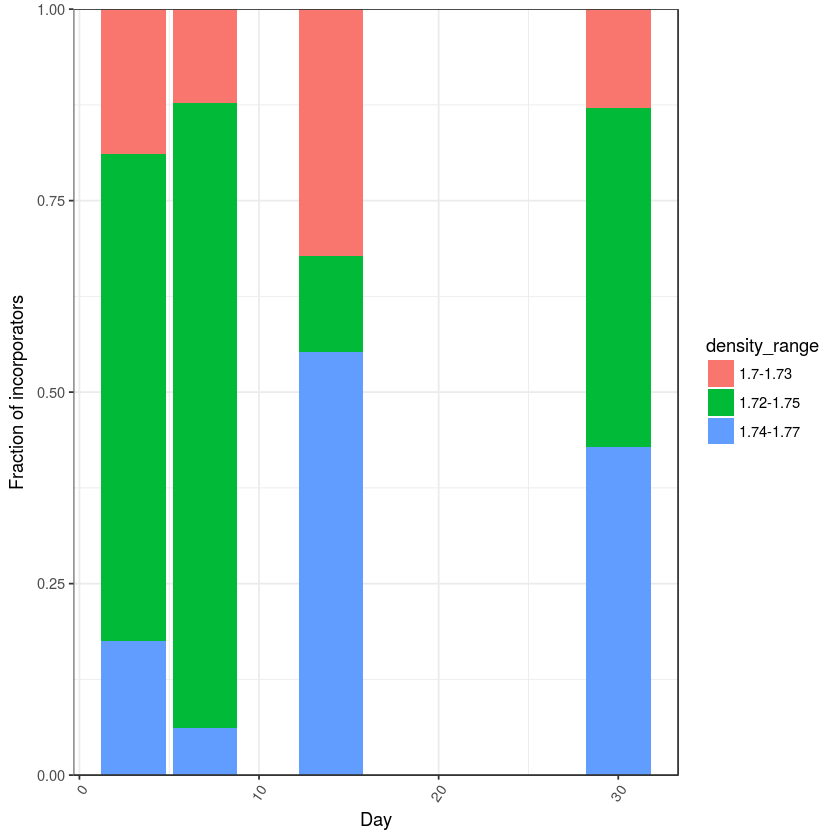

In [14]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(density_range = paste(density_min, density_max, sep='-')) %>% 
  group_by(Day, sparsity_threshold, density_range) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) 

#plotting
ggplot(df_l2fc_s, aes(Day, n_incorp_OTUs, fill=density_range)) +
    geom_bar(stat='identity', position='fill') +
    labs(x='Day', y='Fraction of incorporators') +
    scale_y_continuous(expand=c(0,0)) +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    )

In [15]:
df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(density_range = paste(density_min, density_max, sep='-')) %>% 
  group_by(Day, sparsity_threshold, density_range) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>% 
  ungroup() %>% 
  group_by(Day, sparsity_threshold) %>%
  mutate(total_OTUs = sum(n_incorp_OTUs)) %>%
  mutate(percent_OTUs = n_incorp_OTUs/total_OTUs*100)

Day,sparsity_threshold,density_range,n_incorp_OTUs,total_OTUs,percent_OTUs
3,0.45,1.7-1.73,14,74,18.918919
3,0.45,1.72-1.75,47,74,63.513514
3,0.45,1.74-1.77,13,74,17.567568
7,0.30,1.7-1.73,10,82,12.195122
7,0.30,1.72-1.75,67,82,81.707317
7,0.30,1.74-1.77,5,82,6.097561
14,0.20,1.7-1.73,31,96,32.291667
14,0.20,1.72-1.75,12,96,12.500000
14,0.20,1.74-1.77,53,96,55.208333
30,0.40,1.7-1.73,9,70,12.857143


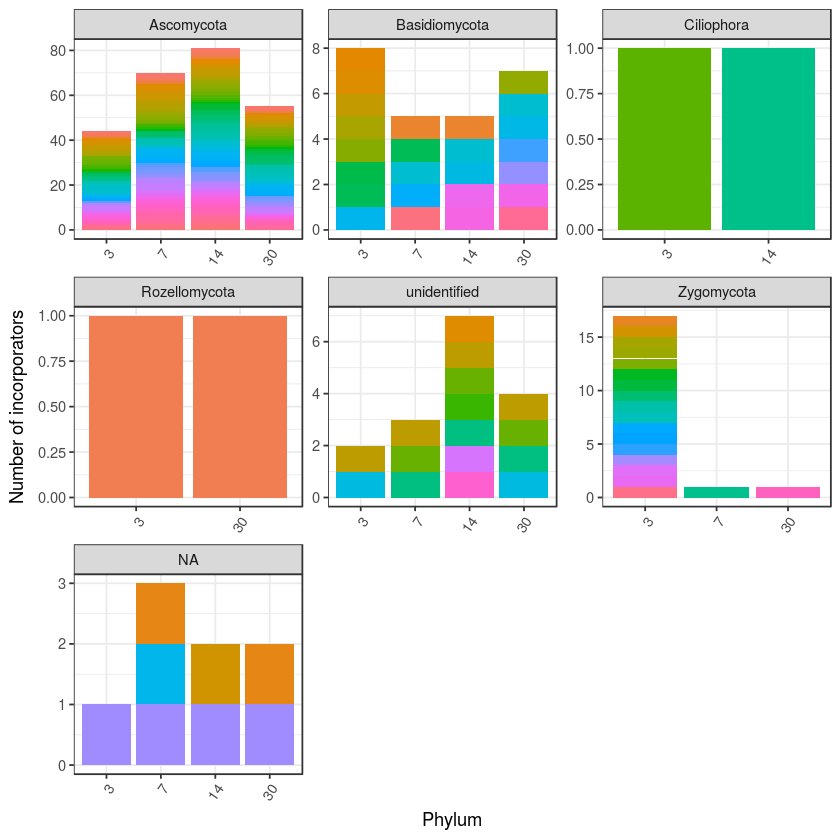

In [16]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank2, OTU) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Phylum', y='Number of incorporators') +
    facet_wrap(~ Rank2, scales='free') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)


In [17]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank2) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>% arrange(Rank2)

df_l2fc_s

Day,Rank2,n_incorp_OTUs
3,Ascomycota,44
7,Ascomycota,70
14,Ascomycota,81
30,Ascomycota,55
3,Basidiomycota,8
7,Basidiomycota,5
14,Basidiomycota,5
30,Basidiomycota,7
3,Ciliophora,1
14,Ciliophora,1


In [18]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < 0.10 & Rank2 == 'p__Zygomycota') %>%
  mutate(Rank2 = gsub('^p__', '', Rank2))



In [19]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank2 = gsub('^p__', '', Rank2)) %>%
  group_by(Day, Rank3, Rank2) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length)  %>% arrange(Rank2)



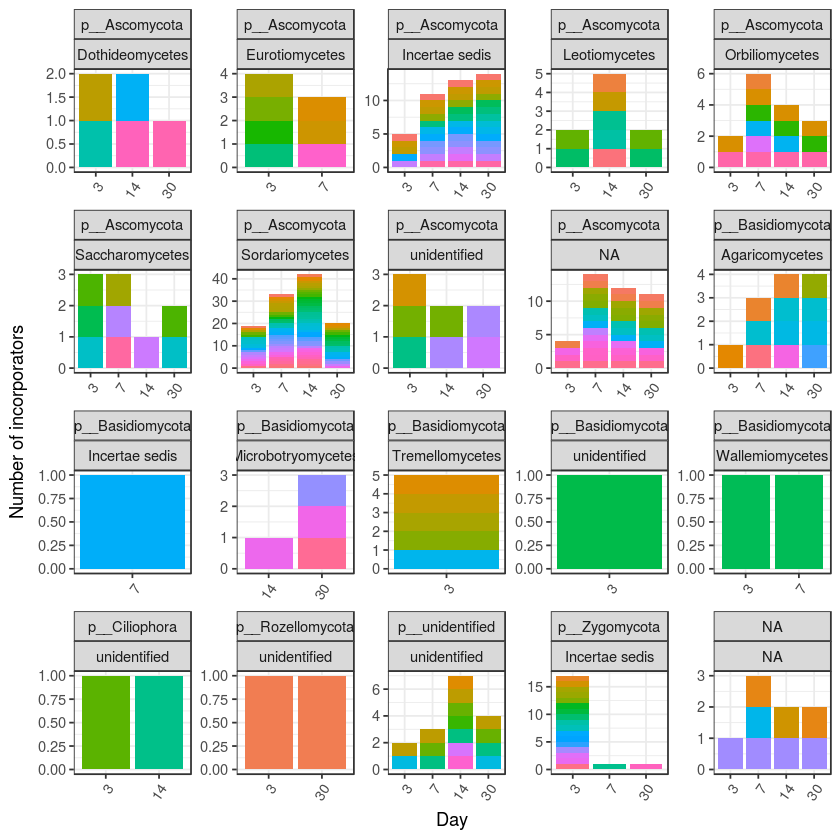

In [20]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Day, Rank3, Rank2, OTU) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Day', y='Number of incorporators') +
    facet_wrap(Rank2~ Rank3, scales='free') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)






[1] 1.728221 7.554533

[1] 4.043595

[1] 1.365679

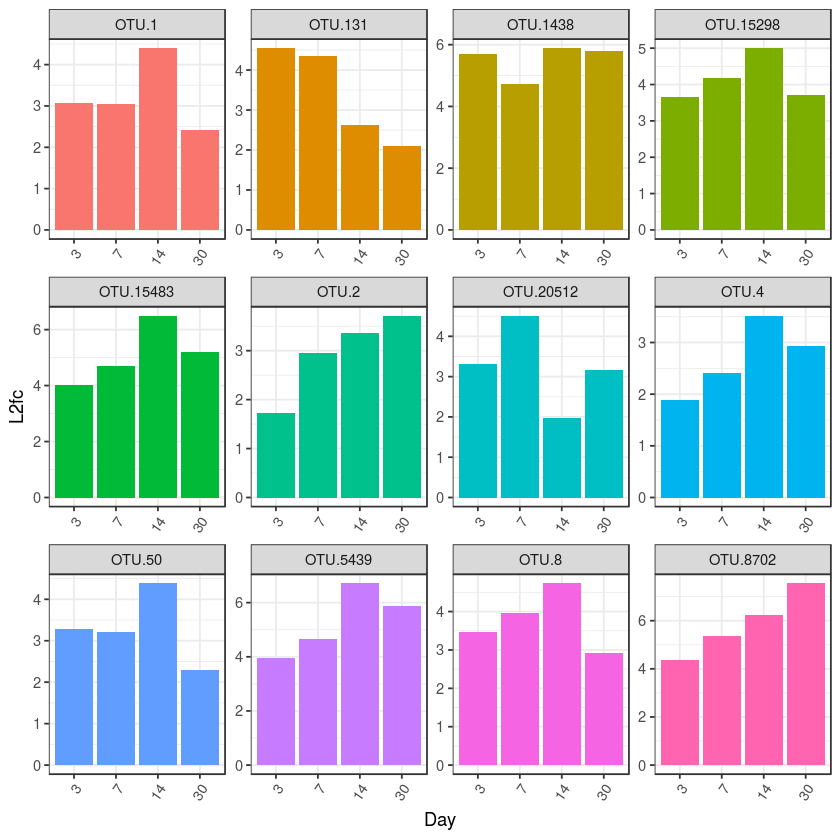

In [21]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(OTU, Rank3, Rank5, Rank6, Rank7) %>%
  summarize(day_incorps = Day %>% unique %>% length) %>%
  filter(day_incorps ==4) %>%
  arrange(Rank3) %>%
  ungroup()


fourdays = filter(df_l2fc2, OTU %in% df_l2fc_s$OTU)
range(fourdays$log2FoldChange)
mean(fourdays$log2FoldChange)
sd(fourdays$log2FoldChange)


ggplot(fourdays, aes(as.factor(Day), log2FoldChange, color)) +
    geom_bar(aes(fill = OTU), stat='identity') +
    labs(x='Day', y='L2fc') +
    facet_wrap(~ OTU, scales='free') +
  #  geom_text(aes(label = (Rank3))) + 
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    ) + guides(fill=FALSE)

In [22]:
filter(df_l2fc2, OTU %in% c('OTU.2', 'OTU.3', 'OTU.8') & padj<0.10) %>% arrange(OTU, Day) %>% select(OTU, Day, log2FoldChange)

OTU,Day,log2FoldChange
OTU.2,3,1.728221
OTU.2,7,2.958096
OTU.2,14,3.351991
OTU.2,30,3.714804
OTU.3,7,2.661521
OTU.3,14,2.316791
OTU.3,30,1.360808
OTU.8,3,3.456544
OTU.8,7,3.972509
OTU.8,14,4.736470


In [23]:
# summarizing
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(OTU, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  group_by(OTU, Rank3) %>%
  summarize(OTU_day = sum(n_incorp_OTUs)) %>%
  #filter(OTU_day > 1) %>%
  group_by(OTU_day, Rank3) %>%
  summarise(cat = OTU %>% unique %>% length) %>% arrange(-cat)

df_l2fc_s

OTU_day,Rank3,cat
1,Sordariomycetes,69
1,Incertae sedis,35
1,NA,21
1,unidentified,17
1,Agaricomycetes,9
1,Eurotiomycetes,7
1,Leotiomycetes,7
1,Saccharomycetes,7
1,Orbiliomycetes,6
1,Dothideomycetes,5


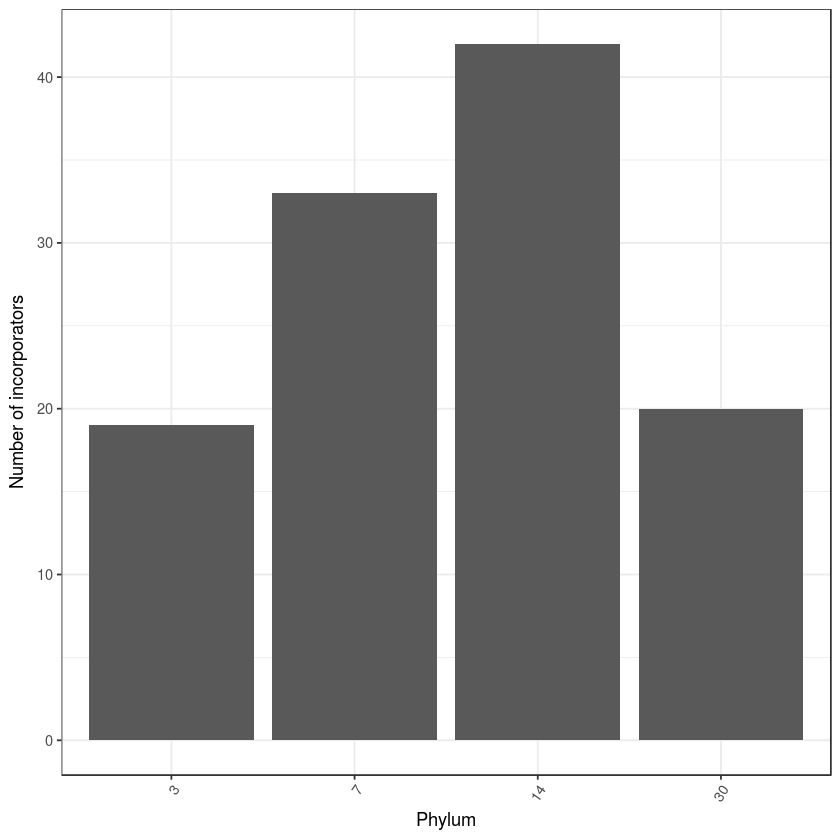

In [24]:
# summarizing
df_l2fc_s = df_l2fc2 %>%   
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  filter(padj < padj_cutoff & Rank3 == "Sordariomycetes") %>%
  group_by(Day, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  ungroup()

# plotting
ggplot(df_l2fc_s, aes(as.factor(Day), n_incorp_OTUs)) +
    geom_bar(stat='identity') +
    labs(x='Phylum', y='Number of incorporators') +
    theme_bw() +
    theme(
      axis.text.x = element_text(angle=55, hjust=1)
    )

In [25]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  group_by(Day, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(Rank3)

df_l2fc_s

Day,Rank3,n_incorp_OTUs
3,Agaricomycetes,1
7,Agaricomycetes,3
14,Agaricomycetes,4
30,Agaricomycetes,4
3,Dothideomycetes,2
14,Dothideomycetes,2
30,Dothideomycetes,1
3,Eurotiomycetes,4
7,Eurotiomycetes,3
3,Incertae sedis,22


In [26]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  mutate(Rank7 = gsub('^s__', '', Rank7)) %>%
  group_by(Rank6, Rank7, Rank3) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(-n_incorp_OTUs)

In [27]:
df_l2fc_s = df_l2fc2 %>% 
  filter(padj < padj_cutoff) %>%
  mutate(Rank3 = gsub('^c__', '', Rank3)) %>%
  mutate(Rank6 = gsub('^g__', '', Rank6)) %>%
  filter(Rank3 == 'Sordariomycetes') %>% 
  group_by(Rank6) %>%
  summarize(n_incorp_OTUs = OTU %>% unique %>% length) %>%
  arrange(-n_incorp_OTUs)


In [74]:
d = df_l2fc2 %>% mutate(Rank3 = gsub('^c__', '', Rank3), Rank2 = gsub('^p__', '', Rank2)) 

d2 = d %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "unclassified",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "unclassified",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))


head(d2)

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold,Rank3_mod
7,OTU.240,-0.6881657,0.9308557,1.0000000,k__Fungi,Ascomycota,Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7,1.73,0.3,all,0.25,Sordariomycetes
7,OTU.85,-0.6977640,0.9645360,1.0000000,k__Fungi,Ascomycota,Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7,1.73,0.3,all,0.25,Eurotiomycetes
7,OTU.26,-0.3061061,0.9902476,1.0000000,k__Fungi,Ascomycota,Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7,1.73,0.3,all,0.25,Sordariomycetes
7,OTU.15,-0.5955299,0.9987957,1.0000000,k__Fungi,Ascomycota,Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7,1.73,0.3,all,0.25,Dothideomycetes
7,OTU.30405,1.4759677,0.1687382,0.7466573,k__Fungi,Ascomycota,Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7,1.73,0.3,all,0.25,Sordariomycetes
7,OTU.190,-0.4806614,0.9238682,1.0000000,k__Fungi,Ascomycota,Dothideomycetes,NA,NA,NA,NA,1.7,1.73,0.3,all,0.25,Dothideomycetes


In [75]:
cols = c("#5c3ba2",
"#65c03c",
"#9c54e3",
"#c7ab2d",
"#ca5bc4",
"#56af6d",
"#c9448b",
"#77963b",
"#7079be",
"#de5c21",
"#5c94b3",
"#cc4438",
"#4fa28b",
"#c2455a",
"#657545",
"#975d83",
"#c08a43",
"#9a6156",
"#a15f3a")

Warning message in brewer.pal(20, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

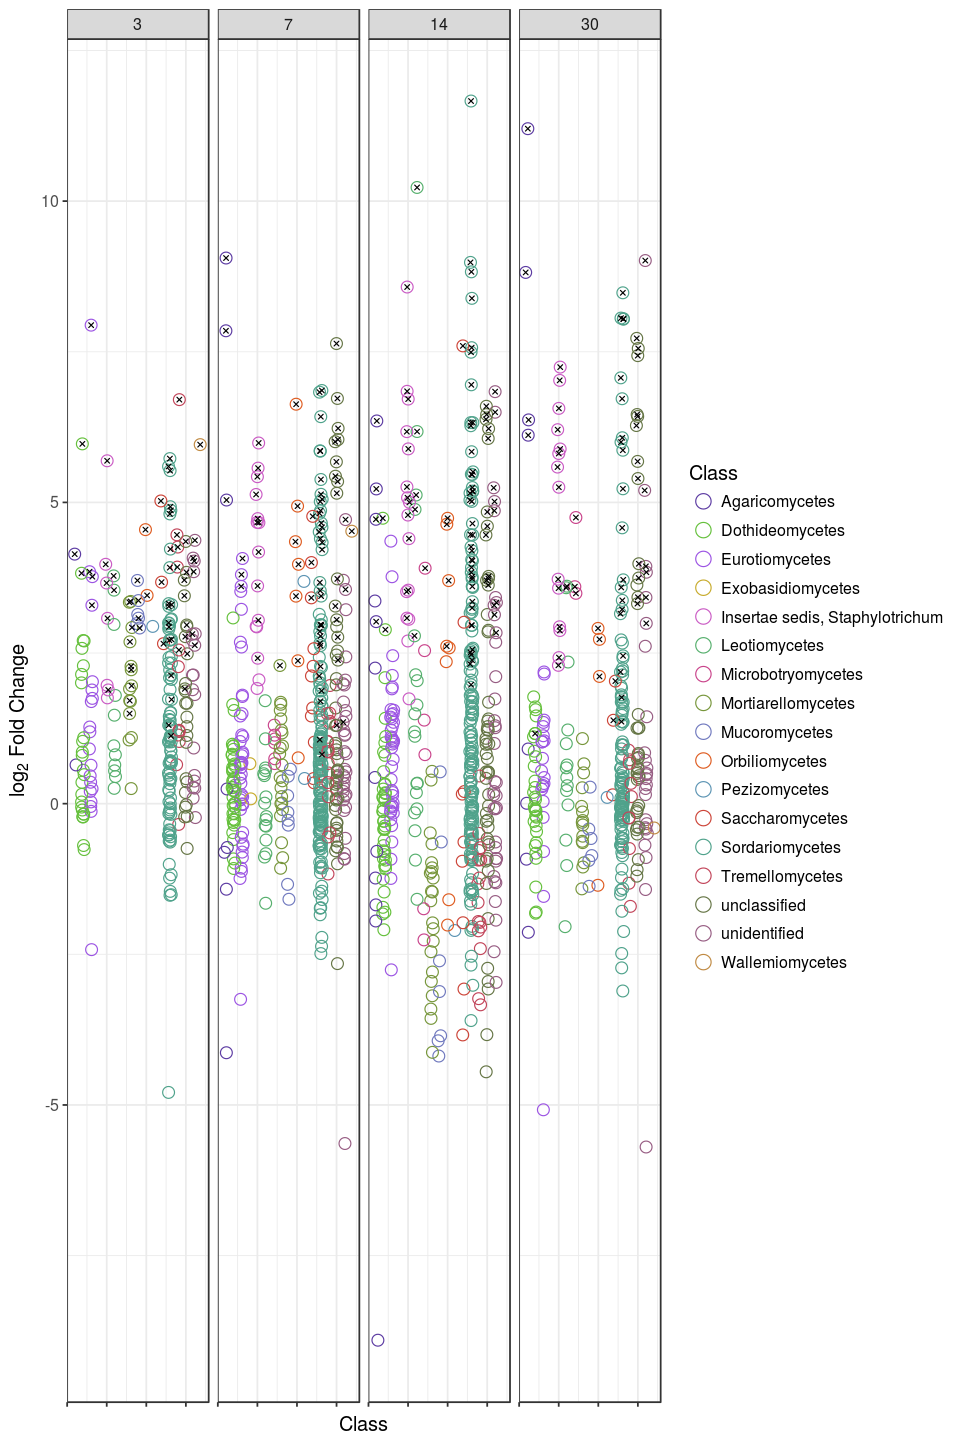

In [99]:
FDR = 0.10
l2fc.threshold = 0.25

d2$Rank3_mod = as.character(d2$Rank3_mod)
d2$Rank3_mod[is.na(d2$Rank3_mod)] = "unclassified"
d2$Rank3_mod = factor(d2$Rank3_mod)


max.l2fc = ddply(d2, .(Rank3_mod), summarize, M = max(log2FoldChange))
d2$Rank3 = factor(d2$Rank3_mod, max.l2fc[order(-max.l2fc$M),]$Rank3_mod)


M = max(as.numeric(d2$Rank3_mod), na.rm = TRUE) + 1
d2$x = as.numeric(d2$Rank3_mod)
d2$x[is.na(d2$x)] = M
d2$x.jitter = d2$x + runif(length(d2$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3_mod)) + 1
getPalette = colorRampPalette(brewer.pal(20, "Dark2"))

p = ggplot(d2, aes(x = x.jitter, y = log2FoldChange, color = Rank3_mod))
p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_color_manual(values = cols)
#p = p + scale_color_brewer(type = 'div', palette = "2")


p = p + geom_point(data = filter(d2, padj <= 0.1), color = "black", shape = 4, size = 1)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=12)) 

p

In [101]:
ggsave(filename = "data/figs/l2fc_byclass_MW.pdf", plot = p, width = 14, height = 5)

Warning message in brewer.pal(20, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

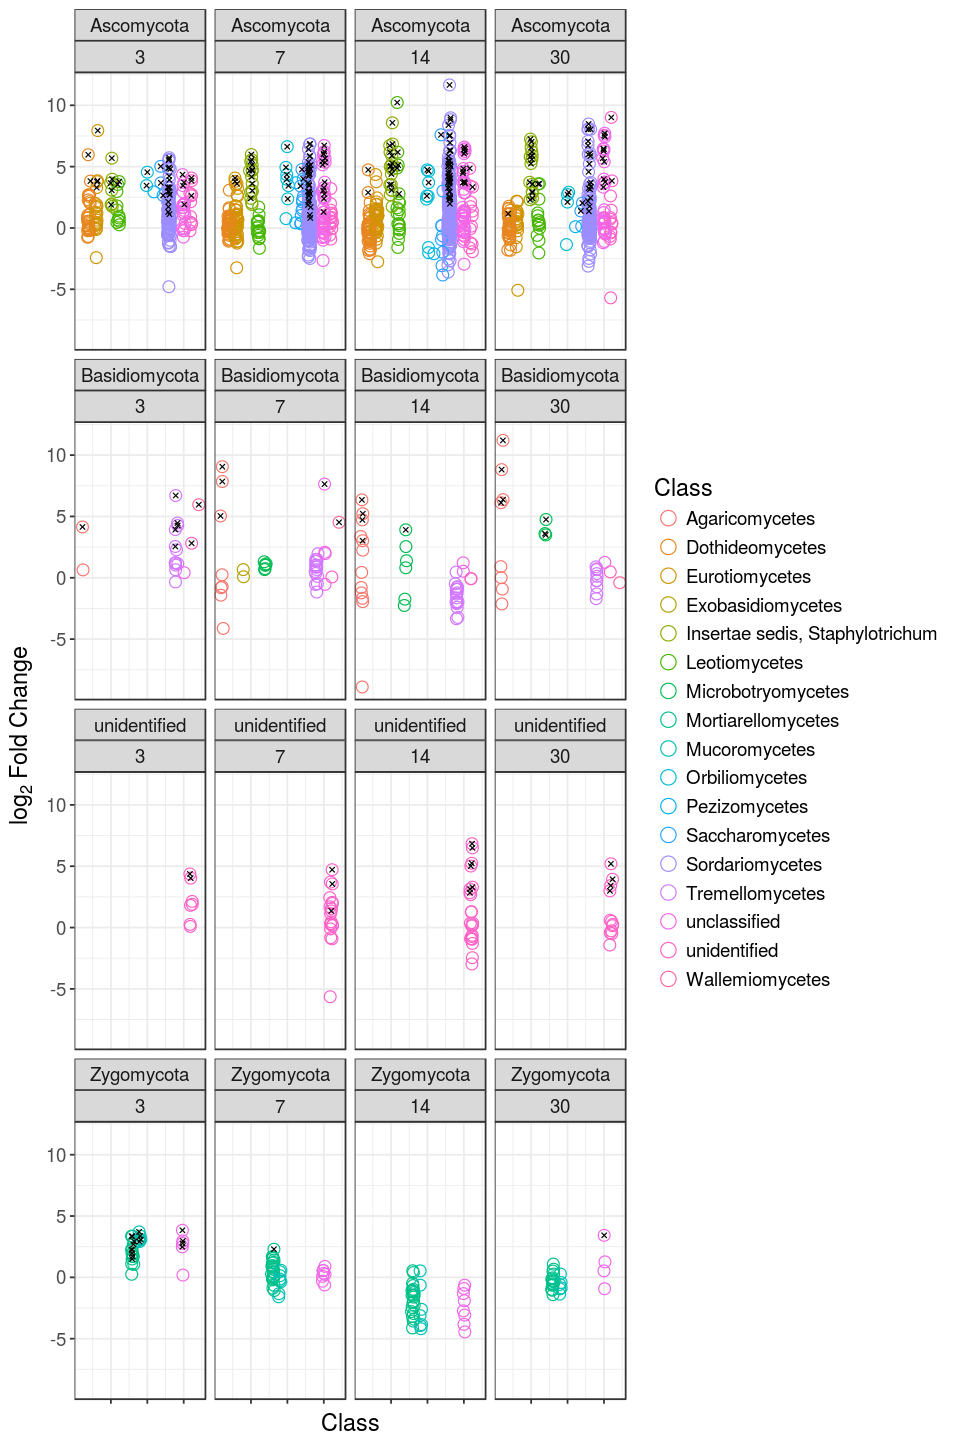

In [85]:
options(repr.plot.width = 8, repr.plot.height = 12)

FDR = 0.10
l2fc.threshold = 0.25

d2$Rank3_mod = as.character(d2$Rank3_mod)
d2$Rank3_mod[is.na(d2$Rank3_mod)] = "unclassified"
d2$Rank3_mod = factor(d2$Rank3_mod)


max.l2fc = ddply(d2, .(Rank3_mod), summarize, M = max(log2FoldChange))
d2$Rank3 = factor(d2$Rank3_mod, max.l2fc[order(-max.l2fc$M),]$Rank3_mod)


M = max(as.numeric(d2$Rank3_mod), na.rm = TRUE) + 1
d2$x = as.numeric(d2$Rank3_mod)
d2$x[is.na(d2$x)] = M
d2$x.jitter = d2$x + runif(length(d2$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3_mod)) + 1
getPalette = colorRampPalette(brewer.pal(20, "Dark2"))

d2 = d2 %>% filter(Rank2 %in% c("Ascomycota", "Basidiomycota", "Zygomycota", "unidentified"))

p = ggplot(d2, aes(x = x.jitter, y = log2FoldChange, color = Rank3_mod))
p = p + facet_wrap(Rank2~Day)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

#p = p + scale_color_manual(values = cols)
#p = p + scale_color_brewer(type = 'div', palette = "2")


p = p + geom_point(data = filter(d2, padj <= 0.1), color = "black", shape = 4, size = 1)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=14)) 

p

In [205]:
d2 %>% filter(padj <= 0.10) %>% group_by(Rank2, Rank3_mod) %>% summarise(count = length(unique(OTU))) %>% 
    arrange(Rank2, -count)

Rank2,Rank3_mod,count
Ascomycota,Sordariomycetes,69
Ascomycota,unclassified,17
Ascomycota,"Insertae sedis, Staphylotrichum",15
Ascomycota,Eurotiomycetes,7
Ascomycota,Leotiomycetes,7
Ascomycota,Saccharomycetes,7
Ascomycota,Orbiliomycetes,6
Ascomycota,Dothideomycetes,5
Ascomycota,unidentified,5
Basidiomycota,Agaricomycetes,9


Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

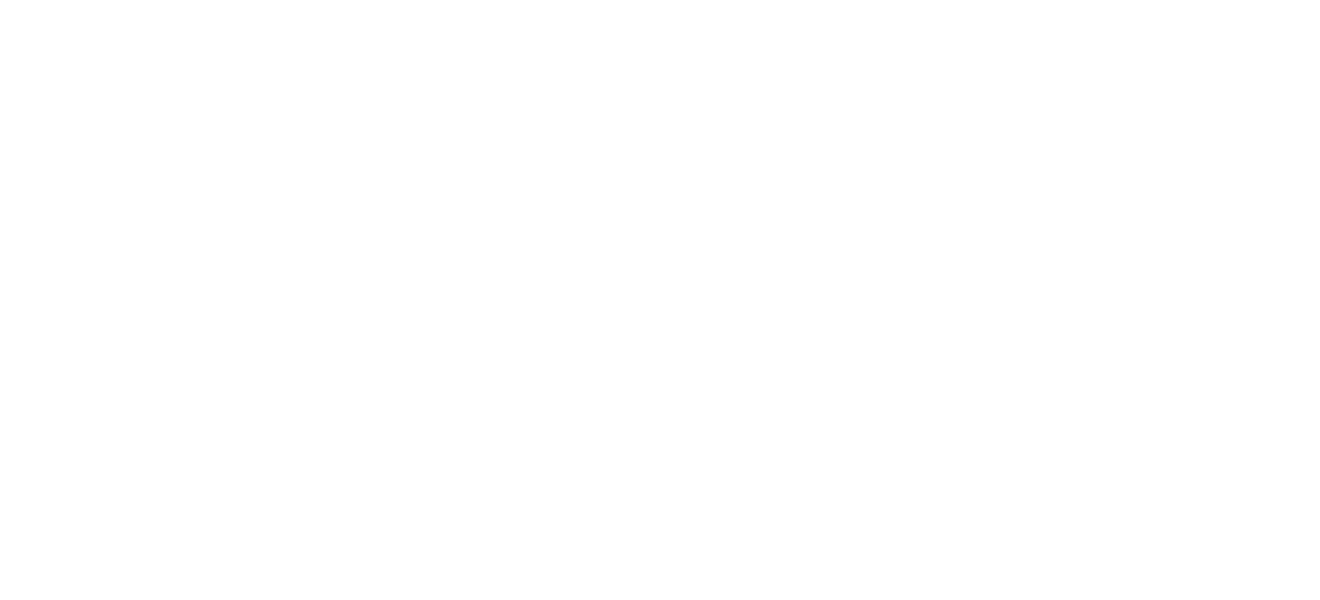

In [64]:
FDR = 0.10
l2fc.threshold = 0.25


d2 = filter(d2, !(Rank3 %in% c("Exobasidiomycetes", "Chytridiomycetes", "Pezizomycetes")))

d2$Rank3_mod = as.character(d2$Rank3_mod)
d2$Rank3_mod[is.na(d2$Rank3_mod)] = "unclassified"
d2$Rank3_mod = factor(d2$Rank3_mod)


max.l2fc = ddply(d2, .(Rank3_mod), summarize, M = max(log2FoldChange))
d2$Rank2 = factor(d2$Rank3_mod, max.l2fc[order(-max.l2fc$M),]$Rank3_mod)


M = max(as.numeric(d2$Rank3_mod), na.rm = TRUE) + 1
d2$x = as.numeric(d2$Rank3_mod)
d2$x[is.na(d2$x)] = M
d2$x.jitter = d2$x + runif(length(d2$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3_mod)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d2, aes(x = x.jitter, y = log2FoldChange, color = Rank3_mod))

p = p + facet_wrap(~Day, nrow=1, ncol=4)

p = p + geom_point(alpha = 1.00, shape = 21, size = 3)

p = p + scale_color_manual(values = getPalette)

p = p + geom_point(data = filter(d2, padj <= 0.1), color = "black", shape = 4, size = 1)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p = p + theme(text = element_text(size=14)) 

p

In [155]:
ggsave(filename = "data/figs/l2fc_byclass_MW.pdf", plot = p, width = 12, height = 7)

Warning message in brewer.pal(10, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”

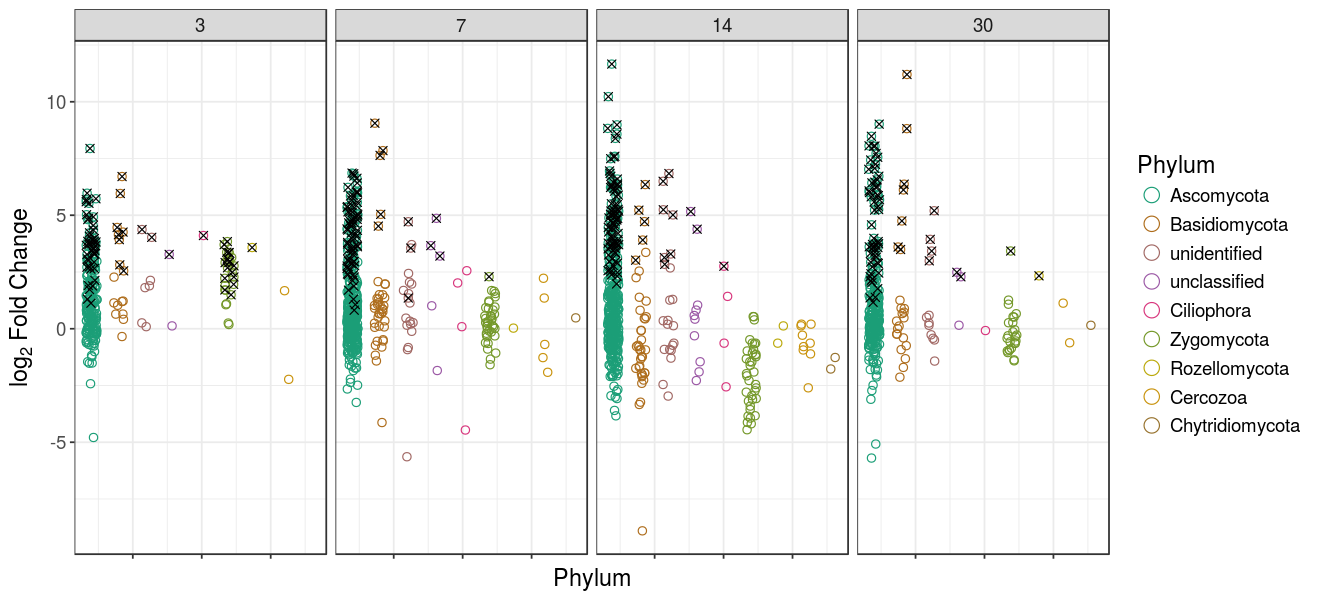

In [58]:

options(repr.plot.width = 11, repr.plot.height = 5)



d = df_l2fc2 %>% mutate(Rank2 = gsub('^p__', '', Rank2)) 

FDR = 0.10
#l2fc.threshold = 2.3

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)



M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p2 = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p2 = p2 + facet_wrap(~as.numeric(Day), nrow=1, ncol=4)

p2 = p2 + geom_point(alpha = 1.00, shape = 21, size = 2)

p2 = p2 + scale_color_manual(values = getPalette(colourCount))

p2 = p2 + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

#p2 = p2 + geom_hline(yintercept = 2.3)

p2 = p2 + theme_bw()

p2 = p2 + theme(axis.text.x = element_blank())

p2 = p2 + labs(x = "Phylum", color = "Phylum")

p2 = p2 + guides(col = guide_legend(ncol = 2))

p2 = p2 + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p2 = p2 + guides(colour = guide_legend(override.aes = list(size=4)))

p2 = p2 + theme(text = element_text(size=14)) 


p2

In [32]:
ggsave(filename = "data/figs/l2fc_byphyla_MW.pdf", plot = p, width = 12, height = 7)

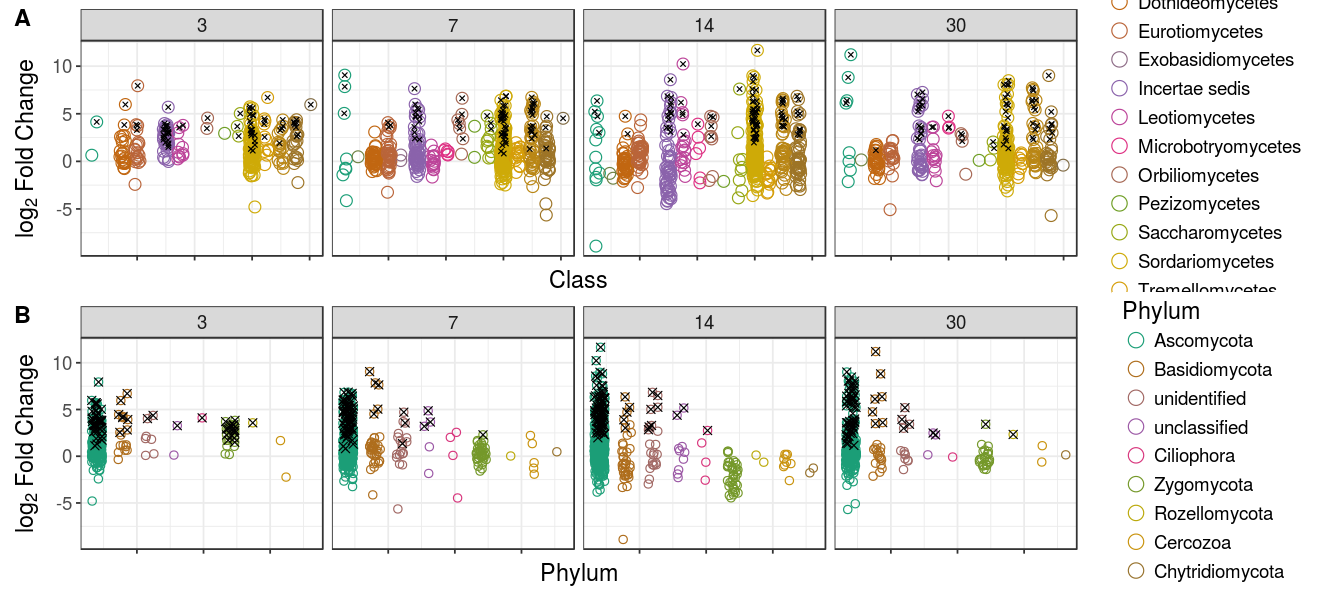

In [33]:
p.l2fc = plot_grid(p, p2, labels = c("A", "B"), nrow = 2, align = "v")

p.l2fc

In [34]:
save_plot("data/figs/l2fc_combo.pdf", p.l2fc,
          ncol = 2, # we're saving a grid plot of 2 columns
          # each individual subplot should have an aspect ratio of 1.3
          base_aspect_ratio = 2
          )


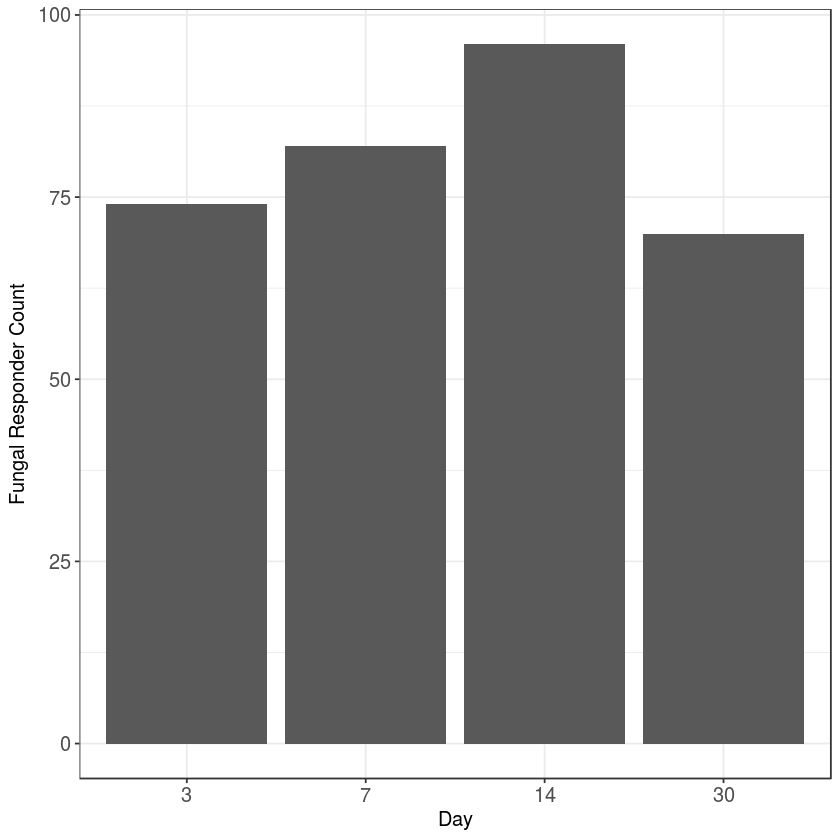

In [132]:
d = df_l2fc2 %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

px = ggplot(d, aes(x = as.factor(Day), y = responders))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + xlab("Day") + ylab("Fungal Responder Count")

px = px + scale_fill_discrete(name = "Day")

px = px + theme_bw()
px = px + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))


px

In [133]:
d

Day,responders
3,74
7,82
14,96
30,70


In [134]:

l2fc.df = tbl_df(read.table("/home/ashley/succ-C-DNASIP/data/l2fc_table.csv",
           sep = ",",
           header = TRUE))
l2fc.df = filter(l2fc.df, Treatment == "13CCPS")

In [135]:
d = l2fc.df %>%
          group_by(Day) %>%
          summarize(responders = sum(padj <= 0.10))

d

Day,responders
3,2
7,5
14,42
30,39


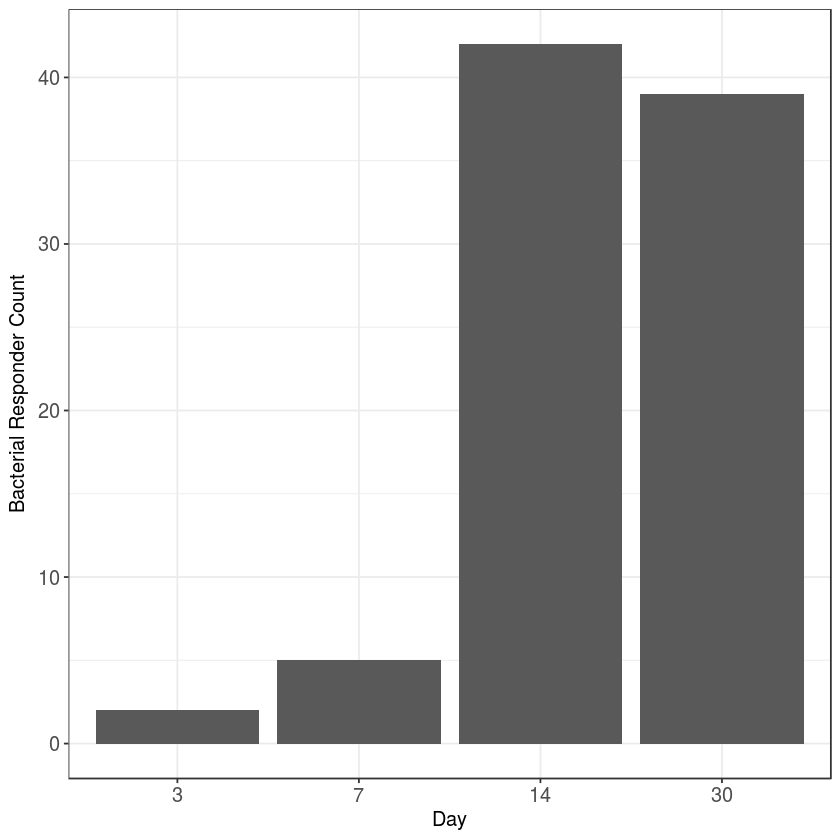

In [136]:
px2 = ggplot(d, aes(x = as.factor(Day), y = responders))

px2 = px2 + geom_bar(stat = "identity", position = "dodge")

px2 = px2 + xlab("Day") + ylab("Bacterial Responder Count")

px2 = px2 + scale_fill_discrete(name = "Day")

px2 = px2 + theme_bw()
px2 = px2 + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))


px2

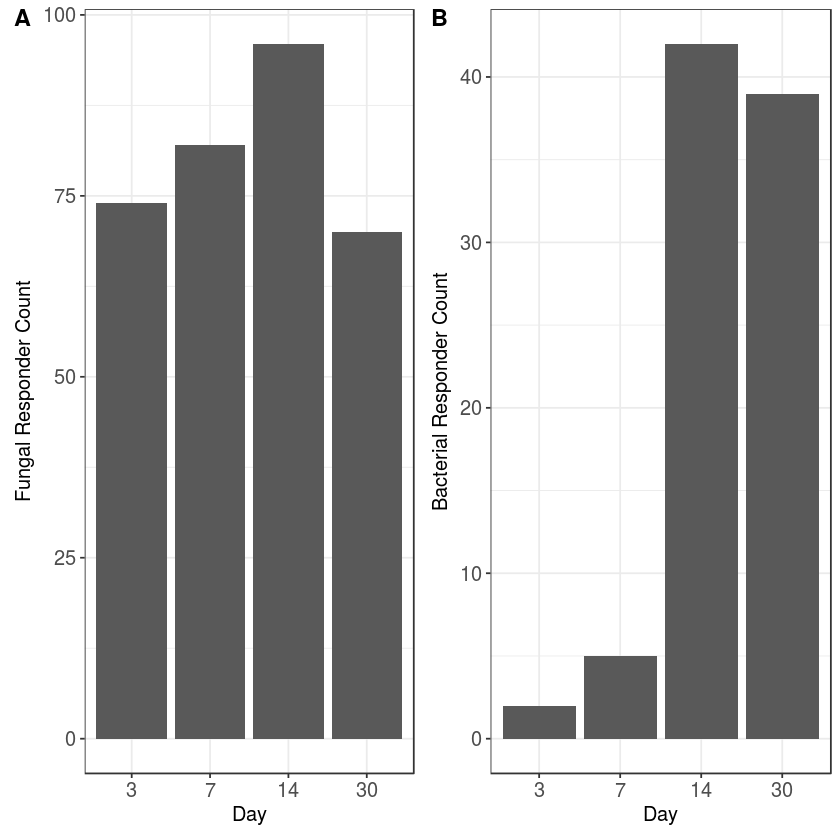

In [137]:
p.bf = plot_grid(px, px2, labels = c("A", "B"), nrow = 1)

p.bf

In [138]:
ggsave(filename = "data/figs/responders_bf.pdf", plot = p.bf, width = 7, height = 3.5, units = "in")

In [139]:
library(tidyr); library(magrittr)


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



In [140]:
data = data.frame(Day = c(0, 3, 7, 14, 30),
                  cellulose = c(100, 88.7, 78.8, 62.4, 39.8)) %>%
    gather(Substrate, "Cellulose Remaining (%)", -Day) %>%
    na.omit
    
data

Day,Substrate,Cellulose Remaining (%)
0,cellulose,100.0
3,cellulose,88.7
7,cellulose,78.8
14,cellulose,62.4
30,cellulose,39.8


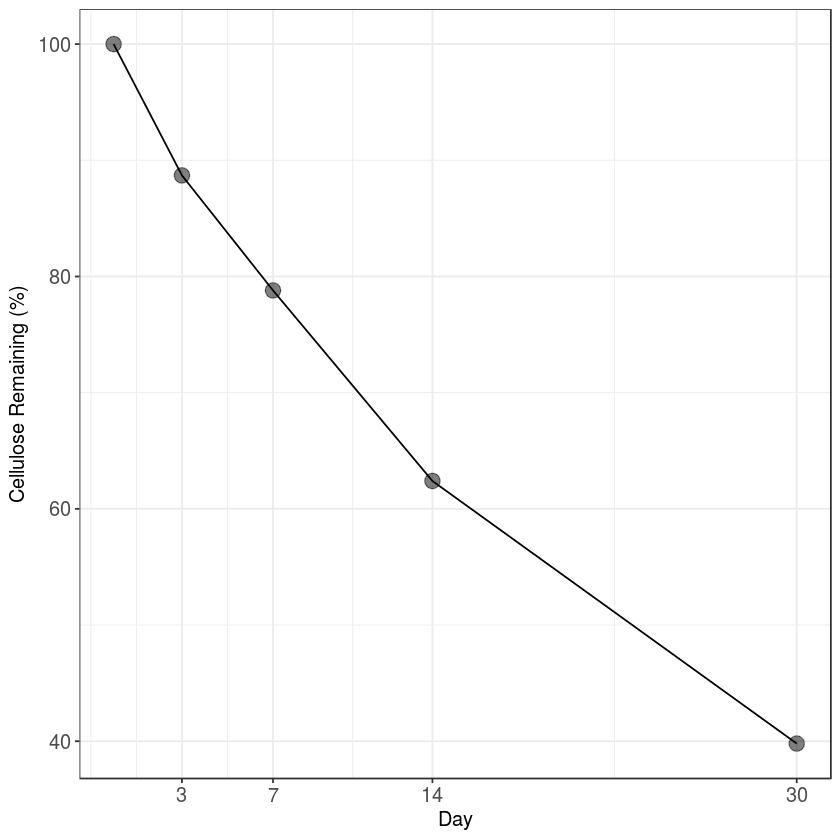

In [148]:
p = ggplot(data, aes(x = Day, y = `Cellulose Remaining (%)`))

p = p + geom_point(size = 4, alpha = 0.5)
p = p + geom_line()
p = p + labs(x = "Day")
p = p + scale_color_manual(values = c("#4daf4a", "#377eb8"))
p = p + theme_bw()
p = p + theme(axis.text = element_text(size = 12),
              axis.title = element_text(size = 12), 
              legend.text = element_text(size = 12), 
              legend.title = element_text(size = 12))
p = p + guides(color = FALSE)

p = p + scale_x_continuous(breaks=c(3, 7, 14, 30))


p

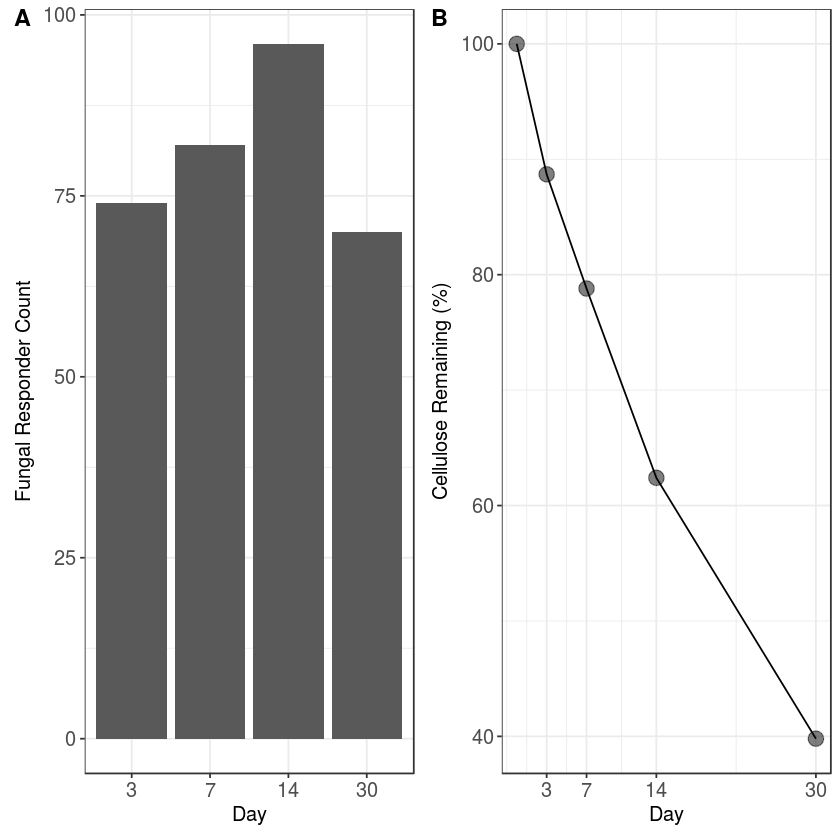

In [149]:
p2 = plot_grid(px, p, labels = c("A", "B"), nrow = 1)

p2

In [44]:
ggsave(filename = "data/figs/responders_by_day_plusCellulose.pdf", plot = p2, width = 7, height = 3.5, units = "in")

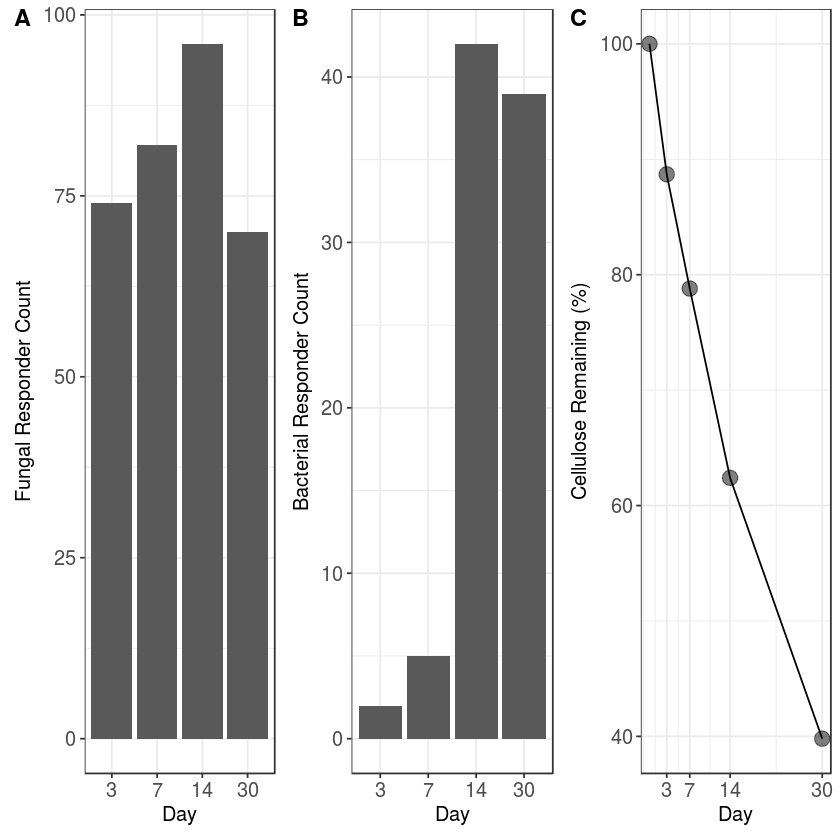

In [152]:
p3 = plot_grid(px, px2,  p, labels = c("A", "B", "C"), nrow = 1)

p3

In [153]:
ggsave(filename = "data/figs/responders_by_day_plusCellulose_bf.pdf", plot = p3, width = 9, height = 3.5, units = "in")

# Combining l2fc info with RA info

In [190]:
#Reading in l2fc data
df_l2fc2 = read.table("data/l2fc_UNITE_MW.csv", sep = ",", header = TRUE)
head(df_l2fc2)

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
7,OTU.240,-6.88e-01,9.31e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Incertae sedis,g__Acremonium,s__Acremonium curvulum,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.85,-6.98e-01,9.65e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Eurotiomycetes,o__Chaetothyriales,f__Herpotrichiellaceae,g__Exophiala,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.26,-3.06e-01,9.90e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,NA,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.15,-5.96e-01,9.99e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Dothideomycetes,o__Pleosporales,f__Pleosporaceae,NA,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.30405,1.48e+00,1.69e-01,7.47e-01,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,s__Fusarium sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.190,-4.81e-01,9.24e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Dothideomycetes,NA,NA,NA,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01


In [191]:
#removing taxonomy prefixes and selecting columns 
df_l2fc2 = df_l2fc2 %>% 
    mutate(Rank6 = gsub('^g__', '', Rank6), 
         Rank7 = gsub('^s__', '', Rank7), 
         Rank2 = gsub('^p__', '', Rank2),
         Rank3 = gsub('^c__', '', Rank3),
         Rank5 = gsub('^f__', '', Rank5),
         Rank4 = gsub('^o__', '', Rank4),
         Rank1 = gsub('^k__', '', Rank1)) %>%
    filter(padj <=0.10, Rank1 == 'Fungi') %>%
    select(c(Day, OTU, Rank1:Rank7)) %>%
    rename(Kingdom = Rank1, Phylum = Rank2, Class = Rank3, Order = Rank4, Family = Rank5, Genus = Rank6, 
           Species = Rank7)

head(df_l2fc2)


Day,OTU,Kingdom,Phylum,Class,Order,Family,Genus,Species
7,OTU.16,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,NA
7,OTU.50,Fungi,NA,NA,NA,NA,NA,NA
7,OTU.10238,Fungi,Ascomycota,Sordariomycetes,unidentified,unidentified,unidentified,Sordariomycetes sp
7,OTU.99,Fungi,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Microdochium,Microdochium sp
7,OTU.53,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Incertae sedis,Acremonium,Acremonium alternatum
7,OTU.144,Fungi,Ascomycota,Sordariomycetes,Sordariales,Lasiosphaeriaceae,NA,NA


In [192]:
#importing relative abundance data
physeq = import_biom("data/SIP_Bulk_otu_table_wtax.biom")

sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)

physeq.md = sample_data(physeq)

physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))&
                               (row.names(physeq.md) %in% grep("succ", row.names(physeq.md), value=TRUE)), physeq) 


physeq.fungi.snorm = transform_sample_counts(physeq.fungi, function(x) x/sum(x))

In [193]:
mdf= tbl_df(psmelt(physeq.fungi.snorm))

In [194]:
#finding unfractionated abundance on day 3 for each OTU
options(scipen = -1)
mdf2 = mdf %>%
    select(OTU, Abundance, Day) %>%
    filter(Day == 3) %>%
    select(-Day) %>%
    group_by(OTU) %>%
    mutate(Ab_round = round(Abundance, 4)) %>%
    summarise('Rel.Ab.' = mean(Abundance))

head(mdf2)# %>% arrange(-Rel.Ab.) %>% head()

OTU,Rel.Ab.
OTU.1,0.00e+00
OTU.10,6.90e-02
OTU.1000,9.86e-05
OTU.1002,1.07e-04
OTU.1003,0.00e+00
OTU.10035,0.00e+00


In [195]:
#Creating combined dataset
options( scipen = -10)
options(digits = 3)

table = left_join(df_l2fc2, mdf2, by = 'OTU') 

table = table %>% arrange(-Rel.Ab.) %>% select(-Kingdom) 

head(table)

Warning message:
“Column `OTU` joining factor and character vector, coercing into character vector”

Day,OTU,Phylum,Class,Order,Family,Genus,Species,Rel.Ab.
7,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
14,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
30,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
3,OTU.6,Zygomycota,Incertae sedis,Mortierellales,Mortierellaceae,Mortierella,NA,5.62e-02
7,OTU.16,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,NA,4.44e-02
3,OTU.16,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,NA,4.44e-02


In [198]:
write.table(table, "data/incorp_table_full.csv", row.names = FALSE, sep = ",")

In [51]:
library(xtable)
full = xtable(table)
print(full, type = "latex",
      math.style.negative = TRUE,
      math.style.exponents = TRUE,
      file="data/figs/FullRespTable.tex",
      include.rownames = FALSE, 
      tabular.environment="longtable")

Warning message in print.xtable(full, type = "latex", math.style.negative = TRUE, :
“Attempt to use "longtable" with floating = TRUE. Changing to FALSE.”

In [52]:
subset_table = table %>% filter(Rel.Ab. > 0.0054) 

sub = xtable(subset_table)
print(sub, 
      type="latex",      
      math.style.negative = TRUE,
      math.style.exponents = TRUE,
      file="data/figs/SubRespTable.tex", 
      include.rownames = FALSE, 
      tabular.environment="longtable")

sub

Warning message in print.xtable(sub, type = "latex", math.style.negative = TRUE, :
“Attempt to use "longtable" with floating = TRUE. Changing to FALSE.”

Day,OTU,Phylum,Class,Order,Family,Genus,Species,Rel.Ab.
7,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
14,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
30,OTU.3,Ascomycota,Sordariomycetes,Xylariales,Incertae sedis,Monographella,Monographella cucumerina,1.40e-01
3,OTU.6,Zygomycota,Incertae sedis,Mortierellales,Mortierellaceae,Mortierella,NA,5.62e-02
7,OTU.16,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,NA,4.44e-02
3,OTU.16,Ascomycota,Sordariomycetes,Hypocreales,Nectriaceae,Fusarium,NA,4.44e-02
7,OTU.2,Ascomycota,Sordariomycetes,Sordariales,unidentified,unidentified,Sordariales sp,3.94e-02
14,OTU.2,Ascomycota,Sordariomycetes,Sordariales,unidentified,unidentified,Sordariales sp,3.94e-02
30,OTU.2,Ascomycota,Sordariomycetes,Sordariales,unidentified,unidentified,Sordariales sp,3.94e-02
3,OTU.2,Ascomycota,Sordariomycetes,Sordariales,unidentified,unidentified,Sordariales sp,3.94e-02


## Looking at uncultivated species (defined : no valid species name)

In [53]:
#sp or NA in name
table %>% 
    filter(is.na(Species) | grepl("sp", Species)) %>%
    summarise(number = length(unique(OTU)))

number
157


In [60]:
#df of OTUs that are uncultivated
uncult = table %>% 
    filter(is.na(Species) | grepl("sp", Species)) %>%
    select(-Day) %>% 
    unique()


In [61]:
#Uncharacterized genera
uncult %>% 
    filter(is.na(Genus) | grepl("unidentified", Genus) | grepl("Incertae sedis", Genus)) %>%
    summarise(number = length(unique(OTU)))

number
93


In [62]:
#Uncharacterized family

uncult %>% 
    filter(is.na(Family) | grepl("unidentified", Family) | grepl("Incertae sedis", Family)) %>%
    summarise(number = length(unique(OTU)))

number
96


In [63]:
#Uncharacterized order

uncult %>% 
    filter(is.na(Order) | grepl("unidentified", Order) | grepl("Incertae sedis", Order)) %>%
    summarise(number = length(unique(OTU)))

number
63


In [64]:
#Uncharacterized class

uncult %>% 
    filter(is.na(Class) | grepl("unidentified", Class) | grepl("Incertae sedis", Class)) %>%
    summarise(number = length(unique(OTU)))

number
64


In [65]:
#Uncharacterized Phylum

uncult %>% 
    filter(is.na(Phylum) | grepl("unidentified", Phylum) | grepl("Incertae sedis", Phylum)) %>%
    summarise(number = length(unique(OTU)))

number
11


## Temporal Patterns and Crossfeeding Analyses

In [66]:
df_l2fc2 = read.table("data/l2fc_UNITE_MW.csv", sep = ",", header = TRUE)
df_l2fc2 = df_l2fc2 %>% filter(OTU %in% table$OTU) #filter to responders, but keeping all days
head(df_l2fc2)

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold
7,OTU.31,1.02e+00,6.81e-02,4.16e-01,k__Fungi,p__Ascomycota,c__Saccharomycetes,o__Saccharomycetales,f__Incertae sedis,g__Candida,s__Candida sake,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.16,8.17e-01,1.07e-02,9.16e-02,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.11310,7.99e-03,5.76e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Leotiomycetes,o__Incertae sedis,f__Incertae sedis,g__Geomyces,s__Geomyces sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.50,3.20e+00,2.28e-04,3.58e-03,k__Fungi,NA,NA,NA,NA,NA,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.10238,5.01e+00,1.14e-05,2.39e-04,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__unidentified,f__unidentified,g__unidentified,s__Sordariomycetes sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01
7,OTU.248,5.49e-01,3.60e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Leotiomycetes,o__Helotiales,f__Helotiaceae,g__Articulospora,s__Articulospora sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01


In [67]:
mdf2 = mdf %>%
    select(OTU, Abundance, Day, ) %>%
    group_by(OTU, Day) %>%
    summarise(meanAb = mean(Abundance))

head(mdf2)

OTU,Day,meanAb
OTU.1,3,0.00e+00
OTU.1,7,0.00e+00
OTU.1,14,0.00e+00
OTU.1,30,0.00e+00
OTU.10,3,6.90e-02
OTU.10,7,9.41e-02


In [68]:
table2 = left_join(df_l2fc2, mdf2)
head(table2)


Joining, by = c("Day", "OTU")
Warning message:
“Column `OTU` joining factor and character vector, coercing into character vector”

Day,OTU,log2FoldChange,p,padj,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,density_min,density_max,sparsity_threshold,sparsity_apply,l2fc_threshold,meanAb
7,OTU.31,1.02e+00,6.81e-02,4.16e-01,k__Fungi,p__Ascomycota,c__Saccharomycetes,o__Saccharomycetales,f__Incertae sedis,g__Candida,s__Candida sake,1.7e+00,1.73e+00,3e-01,all,2.5e-01,2.07e-04
7,OTU.16,8.17e-01,1.07e-02,9.16e-02,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__Hypocreales,f__Nectriaceae,g__Fusarium,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01,2.84e-02
7,OTU.11310,7.99e-03,5.76e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Leotiomycetes,o__Incertae sedis,f__Incertae sedis,g__Geomyces,s__Geomyces sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01,1.04e-04
7,OTU.50,3.20e+00,2.28e-04,3.58e-03,k__Fungi,NA,NA,NA,NA,NA,NA,1.7e+00,1.73e+00,3e-01,all,2.5e-01,9.34e-04
7,OTU.10238,5.01e+00,1.14e-05,2.39e-04,k__Fungi,p__Ascomycota,c__Sordariomycetes,o__unidentified,f__unidentified,g__unidentified,s__Sordariomycetes sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01,9.46e-03
7,OTU.248,5.49e-01,3.60e-01,1.00e+00,k__Fungi,p__Ascomycota,c__Leotiomycetes,o__Helotiales,f__Helotiaceae,g__Articulospora,s__Articulospora sp,1.7e+00,1.73e+00,3e-01,all,2.5e-01,5.18e-04


In [69]:
# Cells below - Attempting to recast data to be able to calculate differences in ab across days
table3 = table2 %>% 
            select(OTU, Day, log2FoldChange, padj, meanAb)

head(table3)

OTU,Day,log2FoldChange,padj,meanAb
OTU.31,7,1.02e+00,4.16e-01,2.07e-04
OTU.16,7,8.17e-01,9.16e-02,2.84e-02
OTU.11310,7,7.99e-03,1.00e+00,1.04e-04
OTU.50,7,3.20e+00,3.58e-03,9.34e-04
OTU.10238,7,5.01e+00,2.39e-04,9.46e-03
OTU.248,7,5.49e-01,1.00e+00,5.18e-04


In [70]:
diff = function(x) {x-lag(x)}

test.sub = table3 %>% group_by(OTU) %>% arrange(Day) %>% mutate_each(funs(delta = diff), c(log2FoldChange, meanAb))

head(test.sub)

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


OTU,Day,log2FoldChange,padj,meanAb,log2FoldChange_delta,meanAb_delta
OTU.8,3,3.46e+00,1.33e-09,2.22e-03,NA,NA
OTU.2,3,1.73e+00,3.76e-05,3.94e-02,NA,NA
OTU.6,3,1.71e+00,1.78e-03,5.62e-02,NA,NA
OTU.105,3,2.13e+00,4.15e-02,1.11e-03,NA,NA
OTU.448,3,2.97e+00,2.91e-03,1.58e-03,NA,NA
OTU.14,3,2.49e+00,1.47e-03,6.33e-03,NA,NA


In [71]:
filter(test.sub, OTU == 'OTU.31')

OTU,Day,log2FoldChange,padj,meanAb,log2FoldChange_delta,meanAb_delta
OTU.31,3,2.66e+00,4.09e-04,1.61e-03,NA,NA
OTU.31,7,1.02e+00,4.16e-01,2.07e-04,-1.63e+00,-1.40e-03
OTU.31,14,-3.84e+00,1.00e+00,3.15e-04,-4.86e+00,1.08e-04
OTU.31,30,1.38e+00,2.80e-02,7.70e-04,5.22e+00,4.55e-04


In [73]:
table4 = table3 %>% unite(vals, log2FoldChange, padj, meanAb) %>% 
                    spread(key = Day, value = vals) %>%
                    separate(`3`, c('D3_LFC', 'D3_padj', 'D3_meanAb'), sep = '_') %>%
                    separate(`7`, c('D7_LFC', 'D7_padj', 'D7_meanAb'), sep = '_') %>%
                    separate(`14`, c('D14_LFC', 'D14_padj', 'D14_meanAb'), sep = '_') %>%
                    separate(`30`, c('D30_LFC', 'D30_padj', 'D30_meanAb'), sep = '_') 



head(table4)

OTU,D3_LFC,D3_padj,D3_meanAb,D7_LFC,D7_padj,D7_meanAb,D14_LFC,D14_padj,D14_meanAb,D30_LFC,D30_padj,D30_meanAb
OTU.1,3.07598488218261e+00,1.98730152988564e-06,0e+00,3.04399574533943e+00,1.36357778821467e-09,0e+00,4.39872073911113e+00,3.85555862149028e-16,0e+00,2.42432301614504e+00,1.6923528205759e-02,0e+00
OTU.10238,1.11246595515351e+00,6.99332041730825e-01,8.74521899068705e-03,5.01253437376669e+00,2.39136841420626e-04,9.45500936490008e-03,3.17493353408746e+00,3.43271915217843e-01,4.93949069195898e-03,NA,NA,NA
OTU.10366,NA,NA,NA,6.00690408327733e+00,2.64423255530592e-11,0e+00,3.73458078100907e+00,1.29359108836697e-02,0e+00,7.43545103581358e+00,5.70345677505979e-16,7.04423781346858e-05
OTU.105,2.12768294097674e+00,4.15098217331582e-02,1.11351458503434e-03,-1.14637001023452e+00,1e+00,1.76348579015684e-03,-1.31283622569165e+00,1e+00,1.40883377399411e-03,-8.63694936204836e-01,1e+00,2.01721888333945e-03
OTU.1062,NA,NA,NA,NA,NA,NA,3.83806263328474e+00,9.26754908909687e-02,0e+00,NA,NA,NA
OTU.107,3.57721824861018e+00,3.09472561041678e-03,1.15881675047784e-03,2.73021492200555e-02,1e+00,1.66087704428194e-03,1.24623560096805e-01,1e+00,1.08581654886424e-03,2.33098275936435e+00,5.72114025967426e-03,8.40854610213371e-04


In [74]:
library(magrittr)

In [75]:
cols = c(2:13)
cols

[1]  2  3  4  5  6  7  8  9 10 11 12 13

In [76]:
table4[,cols] %<>% lapply(function(x) as.numeric(as.character(x)))

In [77]:
head(table4)

OTU,D3_LFC,D3_padj,D3_meanAb,D7_LFC,D7_padj,D7_meanAb,D14_LFC,D14_padj,D14_meanAb,D30_LFC,D30_padj,D30_meanAb
OTU.1,3.08e+00,1.99e-06,0.00e+00,3.04e+00,1.36e-09,0.00e+00,4.40e+00,3.86e-16,0.00e+00,2.42e+00,1.69e-02,0.00e+00
OTU.10238,1.11e+00,6.99e-01,8.75e-03,5.01e+00,2.39e-04,9.46e-03,3.17e+00,3.43e-01,4.94e-03,NA,NA,NA
OTU.10366,NA,NA,NA,6.01e+00,2.64e-11,0.00e+00,3.73e+00,1.29e-02,0.00e+00,7.44e+00,5.70e-16,7.04e-05
OTU.105,2.13e+00,4.15e-02,1.11e-03,-1.15e+00,1.00e+00,1.76e-03,-1.31e+00,1.00e+00,1.41e-03,-8.64e-01,1.00e+00,2.02e-03
OTU.1062,NA,NA,NA,NA,NA,NA,3.84e+00,9.27e-02,0.00e+00,NA,NA,NA
OTU.107,3.58e+00,3.09e-03,1.16e-03,2.73e-02,1.00e+00,1.66e-03,1.25e-01,1.00e+00,1.09e-03,2.33e+00,5.72e-03,8.41e-04


In [78]:
table5 = table4 %>% mutate_each(funs(ifelse(is.na(.),0,.)), -OTU)
head(table5)

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


OTU,D3_LFC,D3_padj,D3_meanAb,D7_LFC,D7_padj,D7_meanAb,D14_LFC,D14_padj,D14_meanAb,D30_LFC,D30_padj,D30_meanAb
OTU.1,3.08e+00,1.99e-06,0.00e+00,3.04e+00,1.36e-09,0.00e+00,4.40e+00,3.86e-16,0.00e+00,2.42e+00,1.69e-02,0.00e+00
OTU.10238,1.11e+00,6.99e-01,8.75e-03,5.01e+00,2.39e-04,9.46e-03,3.17e+00,3.43e-01,4.94e-03,0.00e+00,0.00e+00,0.00e+00
OTU.10366,0.00e+00,0.00e+00,0.00e+00,6.01e+00,2.64e-11,0.00e+00,3.73e+00,1.29e-02,0.00e+00,7.44e+00,5.70e-16,7.04e-05
OTU.105,2.13e+00,4.15e-02,1.11e-03,-1.15e+00,1.00e+00,1.76e-03,-1.31e+00,1.00e+00,1.41e-03,-8.64e-01,1.00e+00,2.02e-03
OTU.1062,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.84e+00,9.27e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00
OTU.107,3.58e+00,3.09e-03,1.16e-03,2.73e-02,1.00e+00,1.66e-03,1.25e-01,1.00e+00,1.09e-03,2.33e+00,5.72e-03,8.41e-04


In [79]:
table6 = table5 %>%
        mutate(d73_LFC = (D7_LFC - D3_LFC),
               d147_LFC = (D14_LFC - D7_LFC), 
               d3014_LFC = (D30_LFC - D7_LFC),
               d73_meanAb = (D7_meanAb - D3_meanAb), 
               d147_meanAb = (D14_meanAb - D7_meanAb), 
               d3014_meanAb = (D30_meanAb - D7_meanAb)) %>%
        select(OTU,d73_LFC, d147_LFC, d3014_LFC, d73_meanAb, d147_meanAb, d3014_meanAb)
head(table6)

OTU,d73_LFC,d147_LFC,d3014_LFC,d73_meanAb,d147_meanAb,d3014_meanAb
OTU.1,-3.20e-02,1.35e+00,-6.20e-01,0.00e+00,0.00e+00,0.00e+00
OTU.10238,3.90e+00,-1.84e+00,-5.01e+00,7.10e-04,-4.52e-03,-9.46e-03
OTU.10366,6.01e+00,-2.27e+00,1.43e+00,0.00e+00,0.00e+00,7.04e-05
OTU.105,-3.27e+00,-1.66e-01,2.83e-01,6.50e-04,-3.55e-04,2.54e-04
OTU.1062,0.00e+00,3.84e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
OTU.107,-3.55e+00,9.73e-02,2.30e+00,5.02e-04,-5.75e-04,-8.20e-04


In [80]:
head(table5)

OTU,D3_LFC,D3_padj,D3_meanAb,D7_LFC,D7_padj,D7_meanAb,D14_LFC,D14_padj,D14_meanAb,D30_LFC,D30_padj,D30_meanAb
OTU.1,3.08e+00,1.99e-06,0.00e+00,3.04e+00,1.36e-09,0.00e+00,4.40e+00,3.86e-16,0.00e+00,2.42e+00,1.69e-02,0.00e+00
OTU.10238,1.11e+00,6.99e-01,8.75e-03,5.01e+00,2.39e-04,9.46e-03,3.17e+00,3.43e-01,4.94e-03,0.00e+00,0.00e+00,0.00e+00
OTU.10366,0.00e+00,0.00e+00,0.00e+00,6.01e+00,2.64e-11,0.00e+00,3.73e+00,1.29e-02,0.00e+00,7.44e+00,5.70e-16,7.04e-05
OTU.105,2.13e+00,4.15e-02,1.11e-03,-1.15e+00,1.00e+00,1.76e-03,-1.31e+00,1.00e+00,1.41e-03,-8.64e-01,1.00e+00,2.02e-03
OTU.1062,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.84e+00,9.27e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00
OTU.107,3.58e+00,3.09e-03,1.16e-03,2.73e-02,1.00e+00,1.66e-03,1.25e-01,1.00e+00,1.09e-03,2.33e+00,5.72e-03,8.41e-04


In [81]:
table.change = table5 %>% 
        mutate(resp_LFC = ifelse(D3_LFC > D7_LFC & D7_LFC > D14_LFC & D14_LFC > D30_LFC, "decreasing",
                                ifelse(D3_LFC < D7_LFC & D7_LFC < D14_LFC & D14_LFC < D30_LFC, "increasing",
                                       ifelse(D3_LFC == D7_LFC & D7_LFC == D14_LFC & D14_LFC == D30_LFC, 'no change',
                                              'mixed')))) %>%
         mutate(resp_meanAb = ifelse(D3_meanAb > D7_meanAb & D7_meanAb > D14_meanAb & D14_meanAb > D30_meanAb, "decreasing", 
                                ifelse(D3_meanAb < D7_meanAb & D7_meanAb < D14_meanAb & D14_meanAb < D30_meanAb, "increasing",
                                       ifelse(D3_meanAb == D7_meanAb & D7_meanAb == D14_meanAb & D14_meanAb == D30_meanAb, 'no change',
                                              'mixed'))))

head(table.change)

OTU,D3_LFC,D3_padj,D3_meanAb,D7_LFC,D7_padj,D7_meanAb,D14_LFC,D14_padj,D14_meanAb,D30_LFC,D30_padj,D30_meanAb,resp_LFC,resp_meanAb
OTU.1,3.08e+00,1.99e-06,0.00e+00,3.04e+00,1.36e-09,0.00e+00,4.40e+00,3.86e-16,0.00e+00,2.42e+00,1.69e-02,0.00e+00,mixed,no change
OTU.10238,1.11e+00,6.99e-01,8.75e-03,5.01e+00,2.39e-04,9.46e-03,3.17e+00,3.43e-01,4.94e-03,0.00e+00,0.00e+00,0.00e+00,mixed,mixed
OTU.10366,0.00e+00,0.00e+00,0.00e+00,6.01e+00,2.64e-11,0.00e+00,3.73e+00,1.29e-02,0.00e+00,7.44e+00,5.70e-16,7.04e-05,mixed,mixed
OTU.105,2.13e+00,4.15e-02,1.11e-03,-1.15e+00,1.00e+00,1.76e-03,-1.31e+00,1.00e+00,1.41e-03,-8.64e-01,1.00e+00,2.02e-03,mixed,mixed
OTU.1062,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.84e+00,9.27e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,mixed,no change
OTU.107,3.58e+00,3.09e-03,1.16e-03,2.73e-02,1.00e+00,1.66e-03,1.25e-01,1.00e+00,1.09e-03,2.33e+00,5.72e-03,8.41e-04,mixed,mixed


In [159]:
table7 = table.change %>% 
            select(OTU, D3_LFC, D7_LFC, D14_LFC, D30_LFC, D3_meanAb, D7_meanAb, D14_meanAb, D30_meanAb, resp_LFC, 
                  resp_meanAb) %>%
            gather(dDay, value, D3_LFC, D7_LFC, D14_LFC, D30_LFC, D3_meanAb, D7_meanAb, D14_meanAb, D30_meanAb) %>%
            separate(dDay, c("Day", "measure"))
head(table7)

OTU,resp_LFC,resp_meanAb,Day,measure,value
OTU.1,mixed,no change,D3,LFC,3.08
OTU.10238,mixed,mixed,D3,LFC,1.11
OTU.10366,mixed,mixed,D3,LFC,0.00
OTU.105,mixed,mixed,D3,LFC,2.13
OTU.1062,mixed,no change,D3,LFC,0.00
OTU.107,mixed,mixed,D3,LFC,3.58


In [83]:
#table7 = table.change %>% 
 #           gather(dDay, dchange, d73_LFC, d147_LFC, d3014_LFC, d73_meanAb, d147_meanAb, d3014_meanAb) %>%
  #          separate(dDay, c("Day", "measure"))
#head(table7)

In [84]:
#table7$Day <- factor(table7$Day, levels = c("d73", "d147", "d3014"))


In [160]:
table7$Day <- factor(table7$Day, levels = c("D3", "D7", "D14", "D30"))


In [161]:
table7 %>% group_by(resp_LFC) %>% summarize(nOTU = length(unique(OTU)))

resp_LFC,nOTU
decreasing,6
increasing,14
mixed,170


In [162]:
table7 %>% group_by(resp_meanAb) %>% summarize(nOTU = length(unique(OTU)))

resp_meanAb,nOTU
decreasing,5
increasing,12
mixed,117
no change,56


In [218]:
sum = table7 %>% group_by(resp_LFC, resp_meanAb) %>% summarize(num = length(unique(OTU)))
sum

resp_LFC,resp_meanAb,num
decreasing,mixed,4
decreasing,no change,2
increasing,increasing,3
increasing,mixed,4
increasing,no change,7
mixed,decreasing,5
mixed,increasing,9
mixed,mixed,109
mixed,no change,47


In [219]:
forprint7 = sum %>% 
            arrange(-num, resp_LFC, resp_meanAb) %>%
            rename('LFC trend' = resp_LFC, 'Rel.Ab. trend' = resp_meanAb, number = num) 

forprint7

LFC trend,Rel.Ab. trend,number
mixed,mixed,109
mixed,no change,47
mixed,increasing,9
increasing,no change,7
mixed,decreasing,5
decreasing,mixed,4
increasing,mixed,4
increasing,increasing,3
decreasing,no change,2


In [220]:
forprint7 = xtable(forprint7)
print(forprint7, type = "latex",
      file="data/figs/LFC_Ab_trends.tex",
      include.rownames = FALSE, 
      tabular.environment="longtable")

Warning message in print.xtable(forprint7, type = "latex", file = "data/figs/LFC_Ab_trends.tex", :
“Attempt to use "longtable" with floating = TRUE. Changing to FALSE.”

In [164]:
table7 %>% group_by(resp_LFC) %>% summarize(num = length(unique(OTU)))

resp_LFC,num
decreasing,6
increasing,14
mixed,170


In [165]:
decreasing = filter(table7, resp_meanAb == 'increasing') 

filter(df_l2fc2, OTU %in% decreasing$OTU) %>% select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>% unique()

OTU,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
OTU.11310,p__Ascomycota,c__Leotiomycetes,o__Incertae sedis,f__Incertae sedis,g__Geomyces,s__Geomyces sp
OTU.50,NA,NA,NA,NA,NA,NA
OTU.248,p__Ascomycota,c__Leotiomycetes,o__Helotiales,f__Helotiaceae,g__Articulospora,s__Articulospora sp
OTU.144,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__Lasiosphaeriaceae,NA,NA
OTU.636,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__Lasiosphaeriaceae,g__unidentified,s__Lasiosphaeriaceae sp
OTU.5,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.2,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp
OTU.20512,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.15542,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.29415,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp


In [166]:
table7 %>% group_by(resp_meanAb) %>% summarize(num = length(unique(OTU)))

resp_meanAb,num
decreasing,5
increasing,12
mixed,117
no change,56


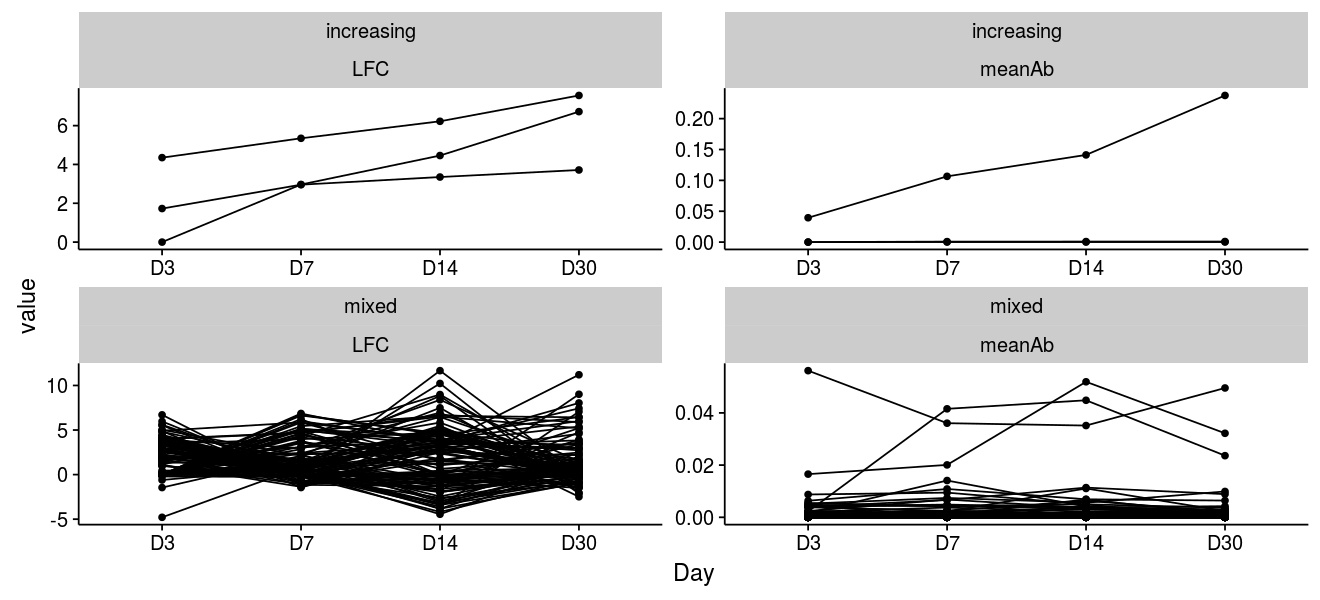

In [167]:
table.same = table7 %>% filter(resp_LFC == resp_meanAb)

p = ggplot(table.same, aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU)) + 
    facet_wrap(resp_meanAb~measure, scales = "free", ncol = 2)

p

In [168]:
summarise(table.same, nOTUs = length(unique(OTU)))

nOTUs
112


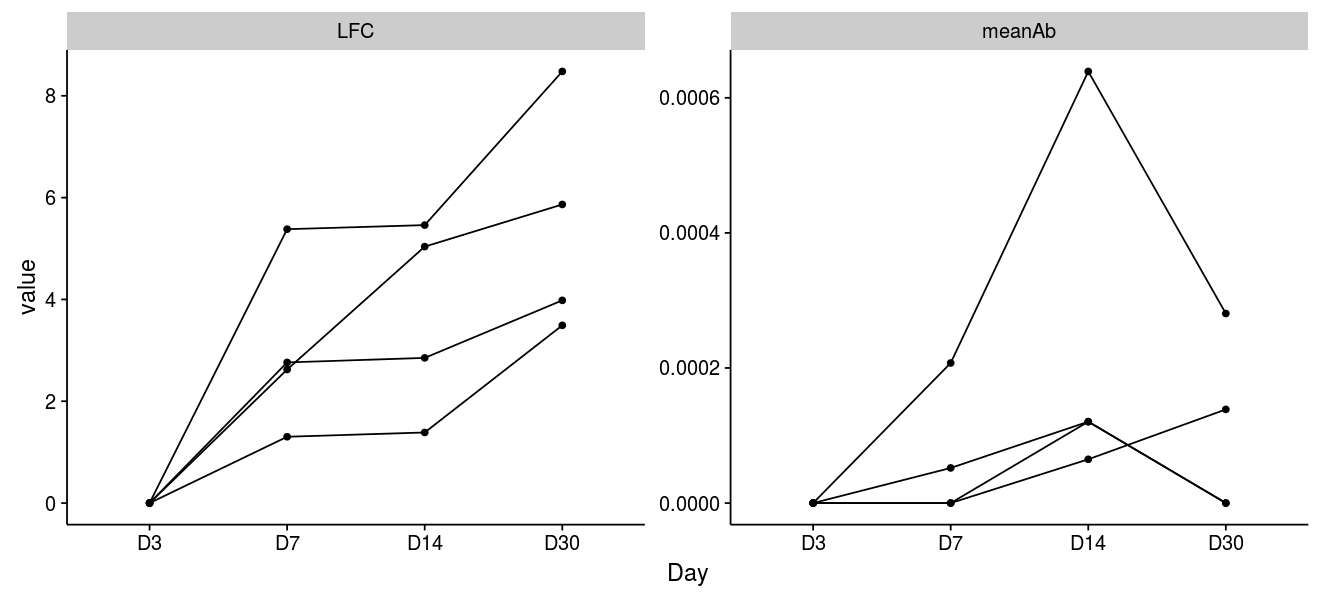

In [169]:
table.same = table7 %>% filter(resp_LFC == "increasing" & resp_meanAb == 'mixed')

p = ggplot(table.same, aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU)) + 
    facet_wrap(~measure, scales = "free", ncol = 2)

p

In [170]:
tail(table7)

,OTU,resp_LFC,resp_meanAb,Day,measure,value
1515,OTU.8815,decreasing,mixed,D30,meanAb,0.00160
1516,OTU.90,mixed,mixed,D30,meanAb,0.00112
1517,OTU.901,mixed,no change,D30,meanAb,0.00000
1518,OTU.98,mixed,mixed,D30,meanAb,0.00014
1519,OTU.99,mixed,mixed,D30,meanAb,0.00112
1520,OTU.9995,mixed,no change,D30,meanAb,0.00000


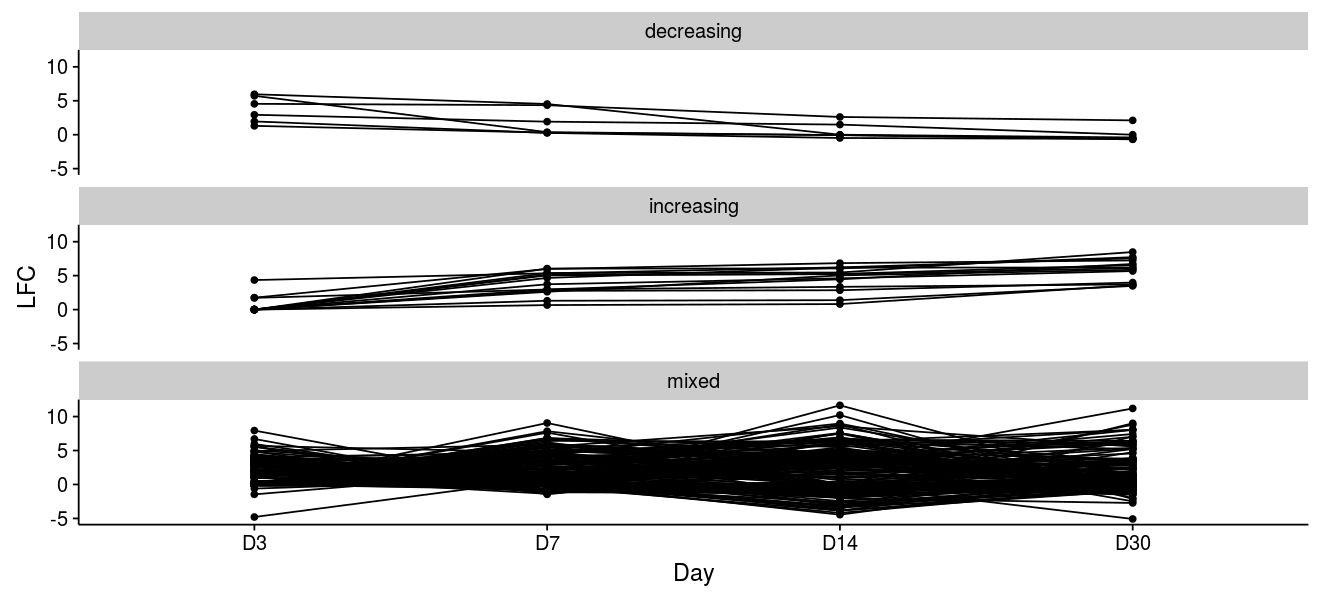

In [201]:
options(scipen=999)
p = ggplot(subset(table7, measure == "LFC"), aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU)) + 
    facet_wrap(~resp_LFC, scales = "fixed", ncol = 1) + ylab("LFC")

p

In [172]:
ggsave(filename = "data/figs/LFCnums.pdf", plot = p, width = 5, height = 10)

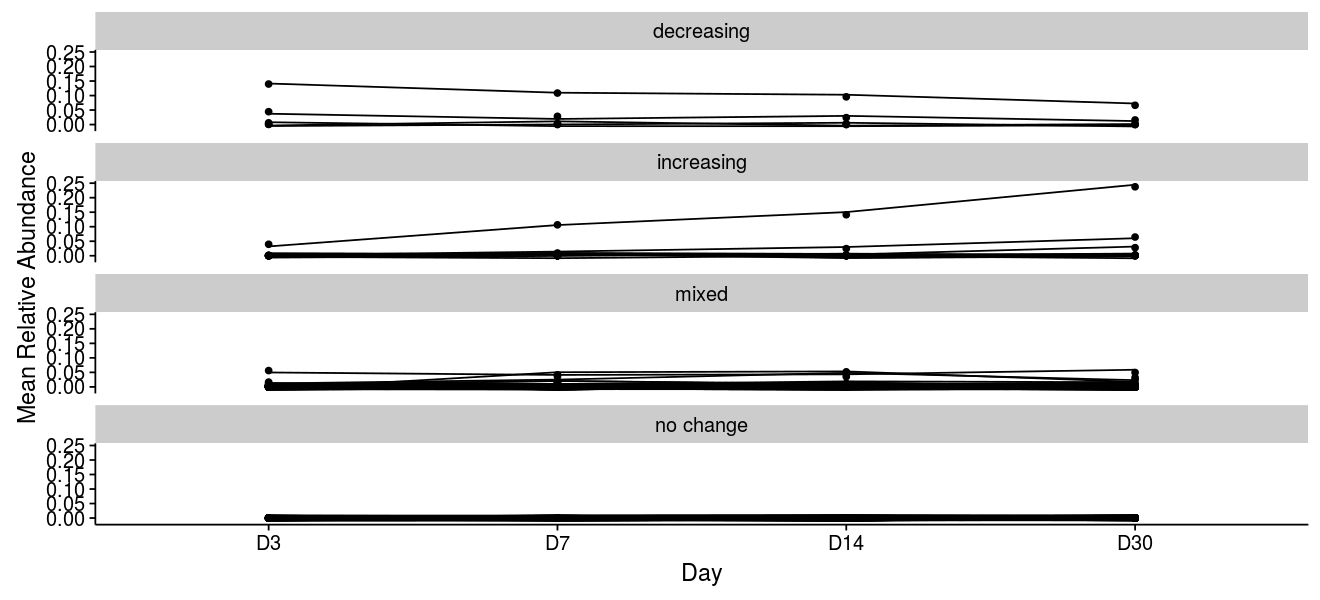

In [173]:
p = ggplot(subset(table7, measure == "meanAb"), aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU), position=position_jitter(w=0, h=0.01)) + 
    facet_wrap(~resp_meanAb, scales = "fixed", ncol = 1) + ylab("Mean Relative Abundance")

p

In [174]:
ggsave(filename = "data/figs/Abnums.pdf", plot = p, width = 5, height = 10)

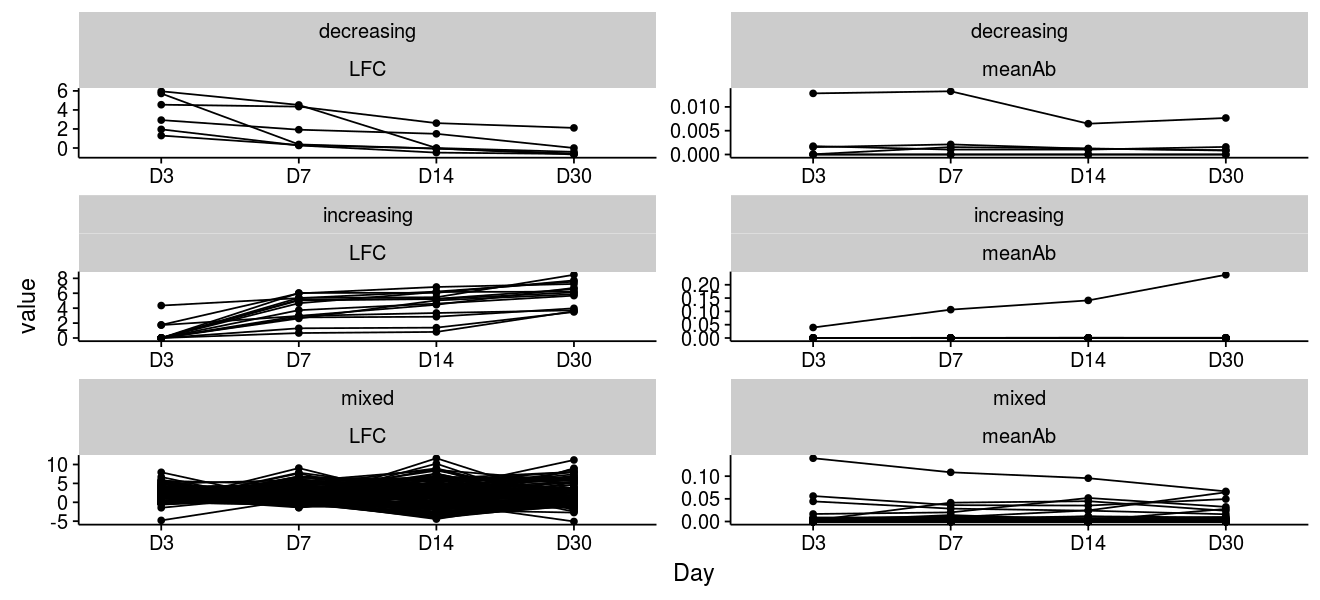

In [202]:
p = ggplot(subset(table7), aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU)) + 
    facet_wrap(resp_LFC ~ measure, scales = "free", ncol = 2)

p


#ggplot(mpg, aes(displ, hwy)) +
#  geom_point() +
 # facet_wrap(c("cyl", "drv"), labeller = "label_both")



In [203]:
ggsave(filename = "data/figs/LFC_Ab_nums.pdf", plot = p, width = 8, height = 10)

In [666]:
filter(table7, resp_LFC == 'decreasing', resp_meanAb == 'decreasing') %>% arrange(OTU)

OTU,resp_LFC,resp_meanAb,Day,measure,value


In [665]:
filter(df_l2fc2, OTU %in% c("OTU.8702", "OTU.2", "OTU.15542")) %>% select(OTU,Rank2, Rank3, Rank4, Rank5, Rank6, Rank7)

OTU,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7
OTU.2,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp
OTU.15542,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.8702,p__Ascomycota,NA,NA,NA,NA,NA
OTU.2,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp
OTU.15542,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.8702,p__Ascomycota,NA,NA,NA,NA,NA
OTU.2,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp
OTU.15542,p__Ascomycota,c__Sordariomycetes,o__Sordariales,NA,NA,NA
OTU.8702,p__Ascomycota,NA,NA,NA,NA,NA
OTU.2,p__Ascomycota,c__Sordariomycetes,o__Sordariales,f__unidentified,g__unidentified,s__Sordariales sp


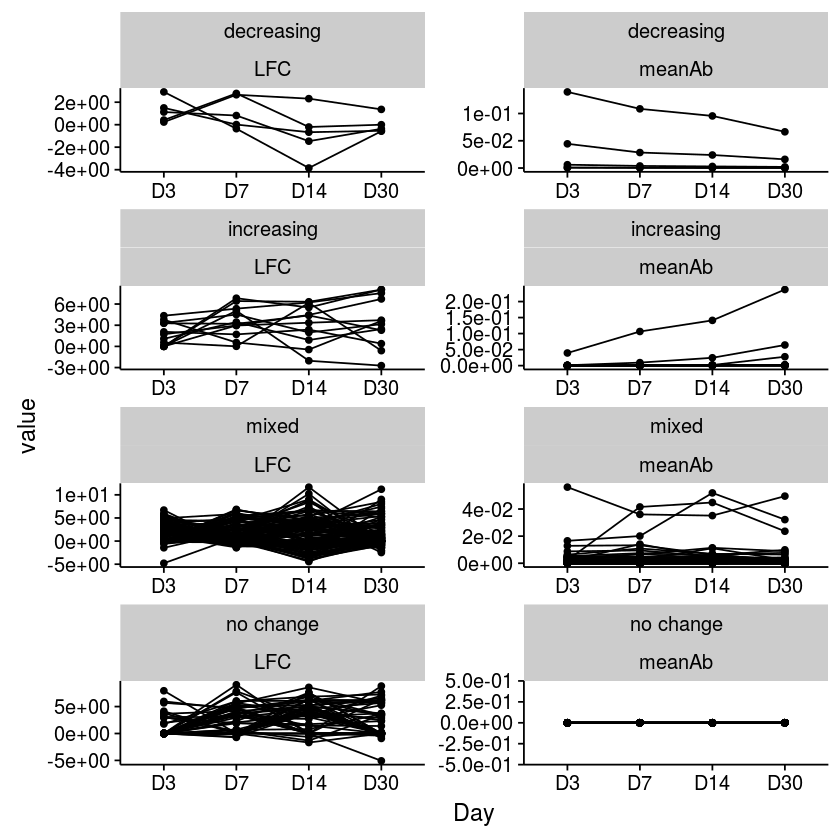

In [632]:

p = ggplot(table7, aes(x = Day, y = value)) +
    geom_point() + 
    geom_line(aes(group = OTU)) + 
    facet_wrap(resp_meanAb~measure, scales = "free", ncol = 2)

p

In [426]:
summarise(table.diff, nOTUs = length(unique(OTU)))

nOTUs
78


In [428]:
test = table7 %>% 
            filter(resp_LFC == 'mixed' | resp_meanAb == 'mixed') 

#ggplot(test, aes(x = ))

In [429]:
head(test)

OTU,resp_LFC,resp_meanAb,Day,measure,value
OTU.1,mixed,no change,D3,LFC,3.075985
OTU.10238,mixed,mixed,D3,LFC,1.112466
OTU.10366,mixed,mixed,D3,LFC,0.000000
OTU.105,mixed,mixed,D3,LFC,2.127683
OTU.1062,mixed,no change,D3,LFC,0.000000
OTU.107,mixed,mixed,D3,LFC,3.577218


In [45]:
sessionInfo()


R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.2 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] magrittr_1.5       cowplot_0.7.0      RColorBrewer_1.1-2 tidyr_0.6.1       
 [5] stringr_1.2.0      data.table_1.10.4  phyloseq_1.19.1    HTSSIP_1.0.3      
 [9] ggplot2_2.2.1      dplyr_0.5.0        plyr_1.8.4        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-5        repr_0.12.0         reshape2_1.4.2     
 [4] splines_3.3.2       lattice_0.20-35     rhdf5_2.18.0       
 [7] colorsp